# Imports + Basic Setup

In [1]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
import tensorflow as tf
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [4]:
df=pd.read_csv('merged_energy_weather_data.csv')

In [5]:
def load_and_split_data(filepath):

    # Load data
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
    df = df.sort_values('datetime').reset_index(drop=True)

    # Create time features
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.weekday
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Define features and target
    target = 'ENGLAND_WALES_DEMAND'

    time_features = ['hour', 'day', 'month', 'year', 'is_weekend', 'weekday']
    weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                        'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    grid_features = [
        'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
        'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
        'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
        'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
        'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
        'VIKING_FLOW', 'GREENLINK_FLOW'
    ]

    feature_cols = weather_features + time_features + grid_features

    # Drop NaN
    model_df = df.dropna(subset=feature_cols + [target]).copy()

    # Temporal split: 2023-2024 = train, 2025 = test
    train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime").reset_index(drop=True)
    test_df = model_df[model_df.year == 2025].sort_values("datetime").reset_index(drop=True)

    print(f"✓ Data loaded: Train={len(train_df)}, Test={len(test_df)}")
    print(f"✓ Features: {len(feature_cols)}, Target: {target}")

    return train_df, test_df, feature_cols, target,model_df


# EDA


Found 1 highly correlated pairs (|r| > 0.8):
  ND <--> TSD : r = 0.982


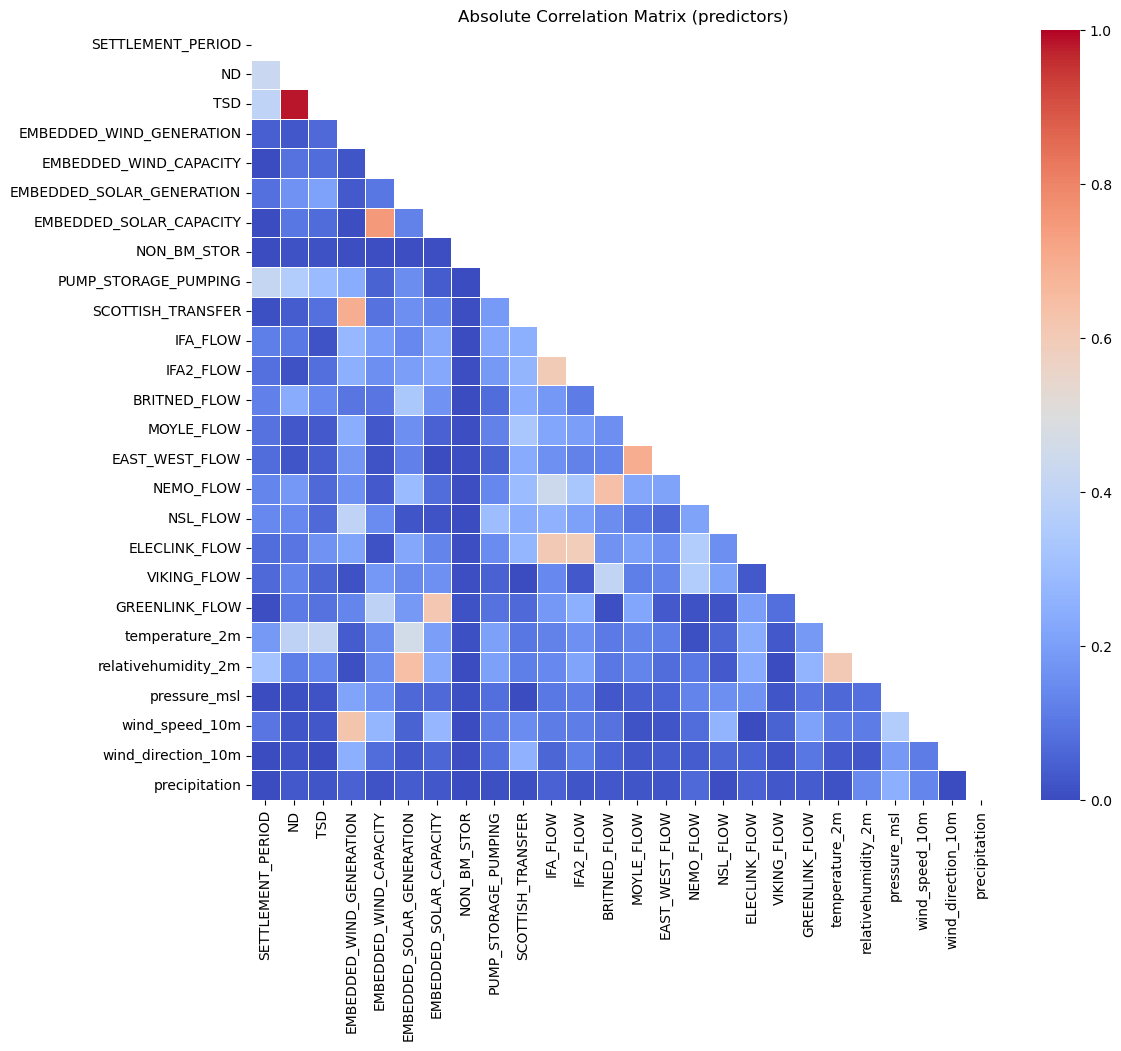

,feature,VIF
4,EMBEDDED_WIND_CAPACITY,12149.669790
22,pressure_msl,10175.550949
2,TSD,2754.400084
1,ND,2421.628251
6,EMBEDDED_SOLAR_CAPACITY,256.403429
21,relativehumidity_2m,71.156328
3,EMBEDDED_WIND_GENERATION,16.801510
23,wind_speed_10m,12.582898
20,temperature_2m,12.179124
0,SETTLEMENT_PERIOD,7.031782



Features with VIF > 10: 9
                 feature          VIF
  EMBEDDED_WIND_CAPACITY 12149.669790
            pressure_msl 10175.550949
                     TSD  2754.400084
                      ND  2421.628251
 EMBEDDED_SOLAR_CAPACITY   256.403429
     relativehumidity_2m    71.156328
EMBEDDED_WIND_GENERATION    16.801510
          wind_speed_10m    12.582898
          temperature_2m    12.179124

Features with 5 < VIF <= 10: 5
           feature      VIF
 SETTLEMENT_PERIOD 7.031782
wind_direction_10m 6.049743
          NSL_FLOW 5.735945
 SCOTTISH_TRANSFER 5.673038
          IFA_FLOW 5.626197

Multicollinearity detected. Consider:
- Removing or combining highly correlated features (shown above).
- Applying dimensionality reduction (PCA) or regularization (Ridge).


In [6]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Correlation + multicollinearity check (corr matrix, high-corr pairs, VIF)


# Select numeric predictors (exclude target)
target_col = 'ENGLAND_WALES_DEMAND'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Drop constant columns and rows with NaNs for the VIF calculation
X_corr = df[numeric_cols].copy()
# Remove cols with zero variance
zero_var = X_corr.columns[X_corr.nunique(dropna=True) <= 1].tolist()
if zero_var:
    print("Dropping zero-variance columns for analysis:", zero_var)
    X_corr = X_corr.drop(columns=zero_var)

# Correlation matrix (absolute)
corr = X_corr.corr().abs()

# Show highly correlated pairs (threshold = 0.8)
threshold = 0.8
high_corr_pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i, j] > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))

print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (|r| > {threshold}):")
for a, b, r in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"  {a} <--> {b} : r = {r:.3f}")

# Heatmap (masked triangle to improve readability)
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=0, vmax=1, linewidths=.5)
plt.title('Absolute Correlation Matrix (predictors)')
plt.show()

# Variance Inflation Factor (VIF)
X_vif = X_corr.dropna()  # VIF requires no NaNs
if X_vif.shape[0] == 0 or X_vif.shape[1] == 0:
    print("Not enough data to compute VIF (no rows or no columns after dropna).")
else:
    # Add small jitter if any perfectly collinear columns cause issues
    X_vif_values = X_vif.values.astype(float)
    vif_data = []
    for i, col in enumerate(X_vif.columns):
        try:
            vif = variance_inflation_factor(X_vif_values, i)
        except Exception as e:
            vif = np.nan
            print(f"VIF error for {col}: {e}")
        vif_data.append((col, vif))
    vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
    display(vif_df.head(40))

    # Flag high VIF features
    high_vif = vif_df[vif_df['VIF'] > 10]
    moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
    print(f"\nFeatures with VIF > 10: {len(high_vif)}")
    if not high_vif.empty:
        print(high_vif.to_string(index=False))
    print(f"\nFeatures with 5 < VIF <= 10: {len(moderate_vif)}")
    if not moderate_vif.empty:
        print(moderate_vif.to_string(index=False))

    # Simple recommendation printout
    if len(high_corr_pairs) == 0 and high_vif.empty:
        print("\nNo strong multicollinearity detected (corr pairs <= 0.8 and VIF <= 10).")
    else:
        print("\nMulticollinearity detected. Consider:")
        print("- Removing or combining highly correlated features (shown above).")
        print("- Applying dimensionality reduction (PCA) or regularization (Ridge).")

In [7]:
# 1. check missing values

In [8]:
df.isnull().sum()

SETTLEMENT_DATE              0
SETTLEMENT_PERIOD            0
ND                           0
TSD                          0
ENGLAND_WALES_DEMAND         0
EMBEDDED_WIND_GENERATION     0
EMBEDDED_WIND_CAPACITY       0
EMBEDDED_SOLAR_GENERATION    0
EMBEDDED_SOLAR_CAPACITY      0
NON_BM_STOR                  0
PUMP_STORAGE_PUMPING         0
SCOTTISH_TRANSFER            0
IFA_FLOW                     0
IFA2_FLOW                    0
BRITNED_FLOW                 0
MOYLE_FLOW                   0
EAST_WEST_FLOW               0
NEMO_FLOW                    0
NSL_FLOW                     0
ELECLINK_FLOW                0
VIKING_FLOW                  0
GREENLINK_FLOW               0
datetime                     0
time                         0
temperature_2m               0
relativehumidity_2m          0
pressure_msl                 0
wind_speed_10m               0
wind_direction_10m           0
precipitation                0
dtype: int64

In [9]:
# 2. check duplicates

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

,SETTLEMENT_DATE,datetime


In [12]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

Negative:          0 rows


In [13]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

Exceed Wind:          0 rows
Exceed Solar:          0 rows


In [14]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

Temperature unrealistic:          0 rows
Wind speed unrealistic:           0 rows
Humidity invalid:                 0 rows
Pressure invalid:                 0 rows
Wind direction invalid:           0 rows
Negative precipitation:           0 rows


In [15]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

In [ ]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [ ]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

In [ ]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [ ]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [ ]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))

In [ ]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [ ]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

In [ ]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [ ]:
# 10. correlation
# check pearson correlation between Demand and weather variables

In [ ]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [ ]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

In [ ]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Preprocessing function

In [16]:
from sklearn.model_selection import TimeSeriesSplit


def iqr_clip_df(df_in, cols):
    """Clip outliers using IQR method"""
    df = df_in.copy()
    clip_info = {}
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
        clip_info[c] = (lower, upper)
    return df, clip_info


def create_lag_features(df, target_col, lag_list):
    """Create lagged features for target variable"""
    df_out = df.copy()
    for lag in lag_list:
        df_out[f'{target_col}_lag_{lag}'] = df_out[target_col].shift(lag)
    return df_out

def create_cyclical_encoding(df, cyclical_cols_info):
    """Create sin/cos encoding for cyclical features"""
    df_out = df.copy()
    for col, max_val in cyclical_cols_info.items():
        if col in df_out.columns:
            df_out[f'{col}_sin'] = np.sin(2 * np.pi * df_out[col] / max_val)
            df_out[f'{col}_cos'] = np.cos(2 * np.pi * df_out[col] / max_val)
    return df_out

def combined_ranking_feature_selection(df, target_col, K=15, mi_random_state=42):
    """
    Selects top K features based on a combined rank score from Pearson,
    Spearman, and Mutual Information (MI) correlation metrics.


    Args:
        df_in (pd.DataFrame): The input DataFrame containing features and target.
        target_col (str): The name of the target column.
        K (int): The number of top features to select.
        mi_random_state (int): Random state for reproducibility of MI calculation.


    Returns:
        list: A list of the top K selected feature names.
    """
    df = df.copy()
    df = df.select_dtypes(include=[np.number])

    features = [col for col in df.columns if col != target_col]
    X = df[features]
    y = df[target_col]
    n_features = len(features)

    # 1. Initialize Rank DataFrame
    rank_df = pd.DataFrame(index=features)

    # --- A. Pearson Rank (Linear) ---
    pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
    rank_df['Pearson_Score'] = pearson_scores
    # Rank: Lower rank is better (i.e., higher score)
    rank_df['Pearson_Rank'] = pearson_scores.rank(ascending=False, method='min')


    # --- B. Spearman Rank (Monotonic Nonlinear) ---
    spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()
    rank_df['Spearman_Score'] = spearman_scores
    rank_df['Spearman_Rank'] = spearman_scores.rank(ascending=False, method='min')


    # --- C. Mutual Information (General Nonlinear) ---
    # MI requires the input features X to be a numpy array, and the target y must be 1D.
    # We must treat features as continuous for mi_regression.
    try:
        # MI is sensitive to scaling, but mi_regression handles it somewhat.
        # It's good practice to ensure non-negative inputs if possible, but not strictly required.
        mi_scores = mutual_info_regression(
            X,
            y,
            random_state=mi_random_state,
            n_neighbors=5 # default setting
        )
        mi_scores = pd.Series(mi_scores, index=features)
    except ValueError as e:
        print(f"Error during Mutual Information calculation: {e}. Are there non-numeric/NaN values?")
        return []


    rank_df['MI_Score'] = mi_scores
    rank_df['MI_Rank'] = mi_scores.rank(ascending=False, method='min')


    # --- 2. Combine Ranks (Median Rank) ---
    rank_df['Combined_Rank'] = rank_df[['Pearson_Rank','Spearman_Rank','MI_Rank']].median(axis=1)


    # Sort by the combined rank (lowest rank/score is best)
    rank_df = rank_df.sort_values('Combined_Rank', ascending=True)


    # --- 3. Keep top K ---
    selected_features = rank_df.head(K).index.tolist()

    print("\n--- Feature Ranking Summary (Top K) ---")
    print(rank_df[['Pearson_Rank', 'Spearman_Rank', 'MI_Rank', 'Combined_Rank']].head(K))


    return selected_features


def feature_selection(df, target_col, K=40):

    # Get the list of top K selected features
    selected_cols = combined_ranking_feature_selection(
        df=df,
        target_col=target_col,
        K=K
    )

    # Ensure the target column is included in the final output
    if target_col not in selected_cols:
        selected_cols.append(target_col)

    return df[selected_cols]

In [17]:
def preprocess_data(train_df, test_df, feature_cols, target,
                   apply_iqr=True, apply_lags=True, apply_cyclical=True):

    train_processed = train_df.copy()
    test_processed = test_df.copy()
    current_feature_cols = feature_cols.copy()

    # Step 1: IQR Clipping
    if apply_iqr:
        print("\nStep 1: IQR Clipping...")
        train_processed[current_feature_cols], clip_info = iqr_clip_df(
            train_processed[current_feature_cols],
            current_feature_cols
        )
        # Apply same clipping bounds to test (using train bounds - NO LEAKAGE)
        for col, (lower, upper) in clip_info.items():
            test_processed[col] = test_processed[col].clip(lower, upper)
        print(f"✓ Applied IQR clipping to {len(current_feature_cols)} features")

    # Step 2: Lag Features
    if apply_lags:
        LAG_HOURS = [1, 2, 3, 6, 12, 24]
        print(f"\nStep 2: Adding lag features {LAG_HOURS}...")
        train_processed = create_lag_features(train_processed, target, LAG_HOURS)
        test_processed = create_lag_features(test_processed, target, LAG_HOURS)

        lag_cols = [col for col in train_processed.columns if col.startswith(f'{target}_lag_')]
        current_feature_cols.extend(lag_cols)
        print(f"Added {len(lag_cols)} lag features")

    # Step 3: Cyclical Encoding
    if apply_cyclical:
        cyclical_info = {'hour': 24, 'day': 31, 'month': 12}
        print(f"\nStep 3: Cyclical encoding for {list(cyclical_info.keys())}...")
        train_processed = create_cyclical_encoding(train_processed, cyclical_info)
        test_processed = create_cyclical_encoding(test_processed, cyclical_info)

        cyclical_cols = [col for col in train_processed.columns
                        if '_sin' in col or '_cos' in col]
        current_feature_cols.extend(cyclical_cols)
        print(f"Added {len(cyclical_cols)} cyclical features")

    # Step 4: Drop NaN rows from lagging
    print(f"\nStep 4: Handling NaN from lag features...")
    train_processed = train_processed.dropna(subset=current_feature_cols + [target])
    test_processed = test_processed.dropna(subset=current_feature_cols + [target])
    print(f"Train: {len(train_df)} → {len(train_processed)} samples")
    print(f"Test: {len(test_df)} → {len(test_processed)} samples")


    # Extract final X and y
    X_train = train_processed[current_feature_cols]
    y_train = train_processed[target]
    X_test = test_processed[current_feature_cols]
    y_test = test_processed[target]

    print(f"\nFinal shapes: X_train={X_train.shape}, X_test={X_test.shape}")
    print(f"Total features: {len(current_feature_cols)}")

    return X_train, X_test, y_train, y_test, current_feature_cols

In [18]:
train_df, test_df, feature_cols, target,model_df = load_and_split_data('merged_energy_weather_data.csv')

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND


In [19]:

selected_cols=feature_selection(model_df,'ENGLAND_WALES_DEMAND')


--- Feature Ranking Summary (Top K) ---
                           Pearson_Rank  Spearman_Rank  MI_Rank  Combined_Rank
ND                                  1.0            1.0      1.0            1.0
TSD                                 2.0            2.0      2.0            2.0
hour                                3.0            3.0      4.0            3.0
SETTLEMENT_PERIOD                   4.0            4.0      3.0            4.0
temperature_2m                      5.0            5.0      8.0            5.0
PUMP_STORAGE_PUMPING                6.0            6.0      7.0            6.0
is_weekend                          7.0            7.0     23.0            7.0
BRITNED_FLOW                        8.0            8.0     14.0            8.0
EMBEDDED_SOLAR_GENERATION           9.0           27.0      9.0            9.0
weekday                            10.0            9.0     21.0           10.0
NEMO_FLOW                          11.0           10.0     22.0           11.0
month      

## Scaling with post-scaling clip

In [20]:
from sklearn.discriminant_analysis import StandardScaler


def scale_data(X_train, X_test, y_train, y_test, clip_value=5.0):

    # Initialize scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # Fit on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    print(f" Features scaled (mean={scaler_X.mean_[:3].round(2)}, std={scaler_X.scale_[:3].round(2)})")
    print(f" Target scaled (mean={scaler_y.mean_[0]:.2f}, std={scaler_y.scale_[0]:.2f})")

    # Post-scaling clip for extreme outliers
    print(f"\nPost-scaling clipping (±{clip_value} std)...")

    X_train_scaled_clipped = np.clip(X_train_scaled, -clip_value, clip_value)
    X_test_scaled_clipped = np.clip(X_test_scaled, -clip_value, clip_value)

    n_clipped_train = np.sum(np.abs(X_train_scaled) > clip_value)
    n_clipped_test = np.sum(np.abs(X_test_scaled) > clip_value)

    if n_clipped_train > 0:
        pct = 100 * n_clipped_train / X_train_scaled.size
        print(f"  Train: Clipped {n_clipped_train} values ({pct:.3f}%)")
    else:
        print(f"  Train: No values exceeded ±{clip_value}")

    if n_clipped_test > 0:
        pct = 100 * n_clipped_test / X_test_scaled.size
        print(f"  Test: Clipped {n_clipped_test} values ({pct:.3f}%)")
    else:
        print(f"  Test: No values exceeded ±{clip_value}")

    print(f" Final ranges: Train=[{X_train_scaled_clipped.min():.2f}, {X_train_scaled_clipped.max():.2f}], "
          f"Test=[{X_test_scaled_clipped.min():.2f}, {X_test_scaled_clipped.max():.2f}]")

    return (X_train_scaled_clipped, X_test_scaled_clipped,
            y_train_scaled, y_test_scaled,
            scaler_X, scaler_y)

## Neural Network Classes

In [21]:
class MLP:
    def __init__(self, input_dim, hidden_units=32, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_dim=self.input_dim),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class LSTM_Model:
    def __init__(self, input_shape, units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size


class TemporalCNN:
    def __init__(self, input_shape, filters=32, epochs=50, batch_size=32):
        self.input_shape = input_shape  # (timesteps, features)
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(max(1, self.filters // 2), kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit(self, X, y, verbose=0):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=verbose)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

    def get_size_mb(self):
        with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
            tmp_name = tmp.name
        # File is now closed
        self.model.save(tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size

## Utility functions

In [22]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def get_model_size_mb(model):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix='.pkl') as tmp:
            tmp_name = tmp.name
        # File is now closed
        joblib.dump(model, tmp_name)
        size = os.path.getsize(tmp_name) / (1024 * 1024)
        try:
            os.remove(tmp_name)
        except PermissionError:
            import time
            time.sleep(0.1)
            try:
                os.remove(tmp_name)
            except:
                pass
        return size
    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

def preprocess_fold(X_fold_train, X_fold_val, y_fold_train, y_fold_val,
                   apply_iqr=True, clip_value=5.0):
    """
    Apply preprocessing independently per fold to avoid leakage

    Args:
        X_fold_train, X_fold_val: Feature data for this fold
        y_fold_train, y_fold_val: Target data for this fold
        apply_iqr: Whether to apply IQR clipping
        clip_value: Post-scaling clip threshold

    Returns:
        X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scalers
    """

    # Step 1: IQR Clipping - using ONLY fold training data
    if apply_iqr:
        Q1 = X_fold_train.quantile(0.25)
        Q3 = X_fold_train.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clip both train and val using TRAINING thresholds
        X_fold_train = X_fold_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
        X_fold_val = X_fold_val.clip(lower=lower_bound, upper=upper_bound, axis=1)

    # Step 2: Scaling - fit ONLY on fold training data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_fold_train)
    y_train_scaled = scaler_y.fit_transform(y_fold_train.values.reshape(-1, 1)).flatten()

    # Transform validation using training statistics
    X_val_scaled = scaler_X.transform(X_fold_val)
    y_val_scaled = scaler_y.transform(y_fold_val.values.reshape(-1, 1)).flatten()

    # Step 3: Post-scaling clip
    if clip_value is not None:
        X_train_scaled = np.clip(X_train_scaled, -clip_value, clip_value)
        X_val_scaled = np.clip(X_val_scaled, -clip_value, clip_value)
        y_train_scaled = np.clip(y_train_scaled, -clip_value, clip_value)
        y_val_scaled = np.clip(y_val_scaled, -clip_value, clip_value)

    scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scalers

## Feature Importance Graph

In [23]:
def analyze_feature_importance(models_dict, feature_cols, top_n=15):
    """
    Analyze and visualize feature importance from tree-based models.
    Uses log scale to better visualize features with very different magnitudes.

    Args:
        models_dict: Dictionary of trained models
        feature_cols: List of feature names
        top_n: Number of top features to display

    Returns:
        importance_df: DataFrame with feature importance scores
    """

    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)

    importance_results = {}

    # Extract from tree-based models
    for model_name in ['XGBoost', 'Random Forest', 'Decision Tree']:
        if model_name in models_dict:
            model = models_dict[model_name]

            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                importance_results[model_name] = importance

                print(f"\nTop {top_n} features for {model_name}:")
                feature_importance = pd.DataFrame({
                    'Feature': feature_cols,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)

                print(feature_importance.head(top_n).to_string(index=False))

    # Visualize
    if len(importance_results) > 0:
        fig, axes = plt.subplots(1, len(importance_results),
                                figsize=(6*len(importance_results), 8))
        if len(importance_results) == 1:
            axes = [axes]

        for idx, (model_name, importance) in enumerate(importance_results.items()):
            feature_importance = pd.DataFrame({
                'Feature': feature_cols,
                'Importance': importance
            }).sort_values('Importance', ascending=False).head(top_n)

            # Use log scale for x-axis
            bars = axes[idx].barh(range(len(feature_importance)),
                                  feature_importance['Importance'],
                                  color='steelblue')

            axes[idx].set_yticks(range(len(feature_importance)))
            axes[idx].set_yticklabels(feature_importance['Feature'], fontsize=10)
            axes[idx].invert_yaxis()
            axes[idx].set_xlabel('Importance Score (log scale)', fontsize=11)
            axes[idx].set_title(f'{model_name} - Top {top_n} Features',
                               fontsize=13, fontweight='bold')
            axes[idx].grid(axis='x', alpha=0.3, which='both')

            # Set log scale
            axes[idx].set_xscale('log')

            # Add percentage labels for clarity
            for i, (bar, val) in enumerate(zip(bars, feature_importance['Importance'])):
                if val > 0.001:  # Only label if >0.1%
                    axes[idx].text(val, i, f' {val*100:.2f}%',
                                  va='center', fontsize=8)

        plt.tight_layout()
        plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: feature_importance_analysis.png")
        plt.show()

    # Create importance DataFrame
    if len(importance_results) > 0:
        importance_df = pd.DataFrame(importance_results, index=feature_cols)
        importance_df['Mean_Importance'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Mean_Importance', ascending=False)

        return importance_df

    return None

## Correlaration analysis

In [24]:
def analyze_feature_correlations(X, y, top_n=20, save_filename='correlation_heatmap.png'):
    """
    Analyze feature correlations with target.

    Args:
        X: Feature dataframe
        y: Target series
        top_n: Number of top correlated features
        save_filename: Filename to save the plot

    Returns:
        correlation_df: DataFrame with correlation scores
    """
    print("\n" + "="*80)
    print("FEATURE CORRELATION ANALYSIS")
    print("="*80)

    # Compute correlations
    correlations = X.corrwith(y).abs().sort_values(ascending=False)

    print(f"\nTop {top_n} features by absolute correlation with target:")
    print(correlations.head(top_n).to_string())

    # Visualize heatmap
    top_features = correlations.head(top_n).index.tolist()

    # Create correlation matrix for top features + target
    data_subset = X[top_features].copy()
    data_subset['target'] = y.values

    corr_matrix = data_subset.corr()

    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f',
                cmap='RdBu_r', center=0,
                square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap - Top {top_n} Features',
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')  # ← USE PARAMETER
    print(f"\n✓ Saved: {save_filename}")
    plt.close()

    return correlations.to_frame('Correlation')

## Error analysis

In [25]:
def analyze_prediction_errors(y_true, predictions_dict, model_names=None):
    """
    Analyze prediction errors across models.

    Args:
        y_true: True target values
        predictions_dict: Dictionary of {model_name: predictions}
        model_names: List of models to analyze (None = all)

    Returns:
        error_stats_df: DataFrame with error statistics
    """

    print("\n" + "="*80)
    print("PREDICTION ERROR ANALYSIS")
    print("="*80)

    if model_names is None:
        model_names = list(predictions_dict.keys())

    # Create subplots
    n_models = len(model_names)
    fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))
    if n_models == 1:
        axes = axes.reshape(2, 1)

    error_stats = []

    for idx, model_name in enumerate(model_names):
        if model_name not in predictions_dict:
            continue

        y_pred = predictions_dict[model_name]
        errors = y_true - y_pred

        # Statistics
        error_stats.append({
            'Model': model_name,
            'Mean_Error': errors.mean(),
            'Std_Error': errors.std(),
            'Min_Error': errors.min(),
            'Max_Error': errors.max(),
            'Q25_Error': np.percentile(errors, 25),
            'Q75_Error': np.percentile(errors, 75)
        })

        # Plot 1: Actual vs Predicted
        axes[0, idx].scatter(y_true, y_pred, alpha=0.3, s=10)
        axes[0, idx].plot([y_true.min(), y_true.max()],
                         [y_true.min(), y_true.max()],
                         'r--', lw=2, label='Perfect Prediction')
        axes[0, idx].set_xlabel('Actual Demand (MW)')
        axes[0, idx].set_ylabel('Predicted Demand (MW)')
        axes[0, idx].set_title(f'{model_name}\nActual vs Predicted')
        axes[0, idx].legend()
        axes[0, idx].grid(alpha=0.3)

        # Plot 2: Residual distribution
        axes[1, idx].hist(errors, bins=50, edgecolor='black', alpha=0.7)
        axes[1, idx].axvline(0, color='r', linestyle='--', lw=2, label='Zero Error')
        axes[1, idx].set_xlabel('Prediction Error (MW)')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].set_title(f'{model_name}\nError Distribution')
        axes[1, idx].legend()
        axes[1, idx].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: error_analysis.png")
    plt.close()

    # Print statistics
    error_stats_df = pd.DataFrame(error_stats)
    print("\nError Statistics:")
    print(error_stats_df.to_string(index=False))

    return error_stats_df

## Temporal error analysis

In [26]:
def analyze_temporal_errors(y_true, predictions_dict, timestamps, model_names=None):
    """
    Analyze how errors vary over time.

    Args:
        y_true: True values
        predictions_dict: Dictionary of predictions
        timestamps: DatetimeIndex or array of timestamps
        model_names: Models to analyze

    Returns:
        temporal_stats_df: DataFrame with temporal error patterns
    """

    print("\n" + "="*80)
    print("TEMPORAL ERROR PATTERN ANALYSIS")
    print("="*80)

    if model_names is None:
        model_names = list(predictions_dict.keys())[:3]  # Top 3 models

    fig, axes = plt.subplots(len(model_names), 1, figsize=(15, 4*len(model_names)))
    if len(model_names) == 1:
        axes = [axes]

    temporal_stats = []

    for idx, model_name in enumerate(model_names):
        if model_name not in predictions_dict:
            continue

        y_pred = predictions_dict[model_name]
        errors = y_true - y_pred

        # Plot errors over time
        axes[idx].plot(timestamps, errors, alpha=0.5, linewidth=0.5, label='Errors')
        axes[idx].axhline(0, color='r', linestyle='--', lw=2, label='Zero Error')
        axes[idx].fill_between(timestamps, errors, 0, alpha=0.2)
        axes[idx].set_xlabel('Time')
        axes[idx].set_ylabel('Prediction Error (MW)')
        axes[idx].set_title(f'{model_name} - Temporal Error Pattern')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

        # Compute statistics by month
        if hasattr(timestamps, 'month'):
            df_temp = pd.DataFrame({
                'error': errors,
                'month': timestamps.month
            })
            monthly_stats = df_temp.groupby('month')['error'].agg(['mean', 'std', 'min', 'max'])

            temporal_stats.append({
                'Model': model_name,
                'Best_Month': monthly_stats['mean'].abs().idxmin(),
                'Worst_Month': monthly_stats['mean'].abs().idxmax(),
                'Max_Std_Month': monthly_stats['std'].idxmax()
            })

    plt.tight_layout()
    plt.savefig('temporal_error_patterns.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: temporal_error_patterns.png")
    plt.close()

    if len(temporal_stats) > 0:
        temporal_stats_df = pd.DataFrame(temporal_stats)
        print("\nTemporal Error Patterns:")
        print(temporal_stats_df.to_string(index=False))
        return temporal_stats_df

    return None

## Statistical significance testing

In [27]:
def test_model_differences(results_df, baseline_model='XGBoost', alpha=0.05):
    """
    Test statistical significance of model performance differences.

    Args:
        results_df: DataFrame with CV results per fold
        baseline_model: Model to compare against
        alpha: Significance level

    Returns:
        significance_df: DataFrame with p-values and conclusions
    """

    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*80)
    print(f"Baseline Model: {baseline_model}")
    print(f"Significance Level: α={alpha}")

    # Get baseline CV scores
    baseline_scores = results_df[results_df['model'] == baseline_model]['r2'].values

    significance_results = []

    for model_name in results_df['model'].unique():
        if model_name == baseline_model:
            continue

        model_scores = results_df[results_df['model'] == model_name]['r2'].values

        # Paired t-test
        t_stat, p_value = stats.ttest_rel(model_scores, baseline_scores)

        # Conclusion
        if p_value < alpha:
            if model_scores.mean() > baseline_scores.mean():
                conclusion = f"Significantly BETTER (p={p_value:.4f})"
            else:
                conclusion = f"Significantly WORSE (p={p_value:.4f})"
        else:
            conclusion = f"No significant difference (p={p_value:.4f})"

        significance_results.append({
            'Model': model_name,
            'Mean_R2': model_scores.mean(),
            'Baseline_Mean_R2': baseline_scores.mean(),
            'Difference': model_scores.mean() - baseline_scores.mean(),
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < alpha else 'No',
            'Conclusion': conclusion
        })

    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('Mean_R2', ascending=False)

    print("\nStatistical Comparison Results:")
    print(significance_df[['Model', 'Mean_R2', 'Difference', 'P_Value', 'Significant']].to_string(index=False))

    return significance_df

## Training function for ML

In [28]:
def train_all_models(X_train_scaled, X_test_scaled,
                    y_train_scaled, y_test_scaled,
                    y_test_original, scaler_y,
                    xgboost_tree_method='hist'):
    """
    Train all models with proper scaling and inverse transforms.

    ALL MODELS receive scaled data.
    ALL PREDICTIONS are inverse-transformed back to original scale.
    ALL METRICS are computed on original scale.

    Args:
        X_train_scaled, X_test_scaled: Scaled features (numpy arrays)
        y_train_scaled, y_test_scaled: Scaled targets (1D numpy arrays)
        y_test_original: Original scale target for metric computation (pandas Series or array)
        scaler_y: Fitted StandardScaler for target
        xgboost_tree_method: XGBoost tree method

    Returns:
        results_df: DataFrame with all model results
        predictions_dict: Dictionary of predictions (original scale)
        models_dict: Dictionary of trained models
    """
    print("\n" + "="*80)
    print("TRAINING ALL MODELS")
    print("="*80)

    results_list = []
    predictions_dict = {}
    models_dict = {}

    # ========================================================================
    # CLASSICAL ML MODELS (Linear Regression, Ridge, SVR, Tree-based)
    # ========================================================================

    classical_models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "SVR": LinearSVR(max_iter=5000),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=xgboost_tree_method
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
    }

    for name, model in classical_models.items():
        print(f"\n{'='*60}")
        print(f"Training: {name}")
        print(f"{'='*60}")

        # Train on SCALED data
        start_time = time.time()
        model.fit(X_train_scaled, y_train_scaled)
        train_time = time.time() - start_time

        # Predict on SCALED data
        start_pred = time.time()
        y_pred_scaled = model.predict(X_test_scaled)
        inference_time = (time.time() - start_pred) / len(X_test_scaled)

        # INVERSE TRANSFORM to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Compute metrics on ORIGINAL scale
        metrics = compute_metrics(y_test_original, y_pred_original)
        model_size = get_model_size_mb(model)

        # Store results
        results_list.append({
            "Model": name,
            **metrics,
            "Training Time (s)": train_time,
            "Inference Time per Sample (s)": inference_time,
            "Model Size (MB)": model_size
        })

        predictions_dict[name] = y_pred_original
        models_dict[name] = model

        print(f"✓ {name} - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # MLP NEURAL NETWORK
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: MLP")
    print(f"{'='*60}")

    mlp = MLP(input_dim=X_train_scaled.shape[1], hidden_units=32, epochs=50, batch_size=32)

    start_time = time.time()
    mlp.fit(X_train_scaled, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = mlp.predict(X_test_scaled)
    inference_time = (time.time() - start_pred) / len(X_test_scaled)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = mlp.get_size_mb()

    results_list.append({
        "Model": "MLP",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["MLP"] = y_pred_original
    models_dict["MLP"] = mlp

    print(f"✓ MLP - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # TEMPORAL CNN
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: Temporal CNN")
    print(f"{'='*60}")

    # Reshape for CNN: (samples, timesteps=1, features)
    X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
    X_test_cnn = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

    cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]), filters=32, epochs=50, batch_size=32)

    start_time = time.time()
    cnn.fit(X_train_cnn, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = cnn.predict(X_test_cnn)
    inference_time = (time.time() - start_pred) / len(X_test_cnn)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = cnn.get_size_mb()

    results_list.append({
        "Model": "Temporal CNN",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["Temporal CNN"] = y_pred_original
    models_dict["Temporal CNN"] = cnn

    print(f"✓ Temporal CNN - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # LSTM (REQUIRES SEQUENCES)
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: LSTM")
    print(f"{'='*60}")

    timesteps = 24
    print(f"Creating sequences with timesteps={timesteps}...")

    # Create sequences from SCALED data
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    print(f"✓ Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

    lstm = LSTM_Model(input_shape=(timesteps, X_train_scaled.shape[1]), units=50, epochs=50, batch_size=32)

    start_time = time.time()
    lstm.fit(X_train_seq, y_train_seq, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = lstm.predict(X_test_seq)
    inference_time = (time.time() - start_pred) / len(X_test_seq)

    # INVERSE TRANSFORM
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # For metrics, use the corresponding y_test_original values (skipping first 'timesteps' samples)
    y_test_original_seq = y_test_original.iloc[timesteps:].values if hasattr(y_test_original, 'iloc') else y_test_original[timesteps:]

    metrics = compute_metrics(y_test_original_seq, y_pred_original)
    model_size = lstm.get_size_mb()

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["LSTM"] = y_pred_original
    models_dict["LSTM"] = lstm

    print(f"✓ LSTM - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # SUMMARY
    # ========================================================================

    results_df = pd.DataFrame(results_list)

    print("\n" + "="*80)
    print("TRAINING COMPLETE")
    print("="*80)
    print(f"✓ Trained {len(results_df)} models")
    print(f"✓ All predictions in original scale")
    print(f"✓ All metrics computed on original scale")

    return results_df, predictions_dict, models_dict


In [29]:
def train_all_models_adaptive_features(X_train_all, X_test_all,
                                       X_train_selected, X_test_selected,
                                       y_train_scaled, y_test_scaled,
                                       y_test_original, scaler_y,
                                       selected_feature_names,
                                       xgboost_tree_method='hist'):
    """
    Train models with adaptive feature selection based on empirical results.

    Strategy (based on feature selection analysis):
    - Neural Networks (MLP, Temporal CNN): Use selected features (K=30)
      → Showed +0.003-0.004 R² improvement
    - Linear Models (Linear Regression, Ridge, SVR): Use selected features (K=30)
      → Showed +0.001-0.003 R² improvement
    - Tree-based Models (XGBoost, Random Forest, Decision Tree): Use all features (K=41)
      → Minimal change, internal feature selection already effective
    - LSTM: Use all features (sequences require more features for temporal patterns)

    Args:
        X_train_all, X_test_all: Scaled features with ALL features (numpy arrays)
        X_train_selected, X_test_selected: Scaled features with SELECTED features (numpy arrays)
        y_train_scaled, y_test_scaled: Scaled targets (1D numpy arrays)
        y_test_original: Original scale target for metric computation
        scaler_y: Fitted StandardScaler for target
        selected_feature_names: List of selected feature names (for documentation)
        xgboost_tree_method: XGBoost tree method

    Returns:
        results_df: DataFrame with model results + feature configuration used
        predictions_dict: Dictionary of predictions (original scale)
        models_dict: Dictionary of trained models
    """
    print("\n" + "="*80)
    print("TRAINING ALL MODELS WITH ADAPTIVE FEATURE SELECTION")
    print("="*80)
    print(f"All features: {X_train_all.shape[1]}")
    print(f"Selected features: {X_train_selected.shape[1]}")
    print("="*80)

    results_list = []
    predictions_dict = {}
    models_dict = {}

    # ========================================================================
    # DEFINE FEATURE STRATEGY FOR EACH MODEL
    # ========================================================================

    # Models using SELECTED features (showed improvement in analysis)
    use_selected = ['Linear Regression', 'Ridge Regression', 'SVR', 'MLP', 'Temporal CNN']

    # Models using ALL features (tree-based + LSTM)
    use_all = ['Decision Tree', 'XGBoost', 'Random Forest', 'LSTM']

    # ========================================================================
    # CLASSICAL ML MODELS
    # ========================================================================

    classical_models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "SVR": LinearSVR(max_iter=5000),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=xgboost_tree_method
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
    }

    for name, model in classical_models.items():
        print(f"\n{'='*60}")

        # Determine which feature set to use
        if name in use_selected:
            X_train = X_train_selected
            X_test = X_test_selected
            feature_config = f"Selected (K={X_train_selected.shape[1]})"
            print(f"Training: {name} with SELECTED features")
        else:
            X_train = X_train_all
            X_test = X_test_all
            feature_config = f"All (K={X_train_all.shape[1]})"
            print(f"Training: {name} with ALL features")

        print(f"{'='*60}")

        # Train on appropriate feature set
        start_time = time.time()
        model.fit(X_train, y_train_scaled)
        train_time = time.time() - start_time

        # Predict
        start_pred = time.time()
        y_pred_scaled = model.predict(X_test)
        inference_time = (time.time() - start_pred) / len(X_test)

        # Inverse transform to original scale
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # Compute metrics on original scale
        metrics = compute_metrics(y_test_original, y_pred_original)
        model_size = get_model_size_mb(model)

        # Store results with feature configuration
        results_list.append({
            "Model": name,
            "Feature_Config": feature_config,
            "Num_Features": X_train.shape[1],
            **metrics,
            "Training Time (s)": train_time,
            "Inference Time per Sample (s)": inference_time,
            "Model Size (MB)": model_size
        })

        predictions_dict[name] = y_pred_original
        models_dict[name] = model

        print(f"✓ {name} [{feature_config}] - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # MLP NEURAL NETWORK (Use SELECTED features)
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: MLP with SELECTED features")
    print(f"{'='*60}")

    X_train = X_train_selected
    X_test = X_test_selected
    feature_config = f"Selected (K={X_train_selected.shape[1]})"

    mlp = MLP(input_dim=X_train.shape[1], hidden_units=32, epochs=50, batch_size=32)

    start_time = time.time()
    mlp.fit(X_train, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = mlp.predict(X_test)
    inference_time = (time.time() - start_pred) / len(X_test)

    # Inverse transform
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = mlp.get_size_mb()

    results_list.append({
        "Model": "MLP",
        "Feature_Config": feature_config,
        "Num_Features": X_train.shape[1],
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["MLP"] = y_pred_original
    models_dict["MLP"] = mlp

    print(f"✓ MLP [{feature_config}] - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # TEMPORAL CNN (Use SELECTED features)
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: Temporal CNN with SELECTED features")
    print(f"{'='*60}")

    X_train = X_train_selected
    X_test = X_test_selected
    feature_config = f"Selected (K={X_train_selected.shape[1]})"

    # Reshape for CNN: (samples, timesteps=1, features)
    X_train_cnn = X_train.reshape(len(X_train), 1, -1)
    X_test_cnn = X_test.reshape(len(X_test), 1, -1)

    cnn = TemporalCNN(input_shape=(1, X_train.shape[1]), filters=32, epochs=50, batch_size=32)

    start_time = time.time()
    cnn.fit(X_train_cnn, y_train_scaled, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = cnn.predict(X_test_cnn)
    inference_time = (time.time() - start_pred) / len(X_test_cnn)

    # Inverse transform
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics = compute_metrics(y_test_original, y_pred_original)
    model_size = cnn.get_size_mb()

    results_list.append({
        "Model": "Temporal CNN",
        "Feature_Config": feature_config,
        "Num_Features": X_train.shape[1],
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["Temporal CNN"] = y_pred_original
    models_dict["Temporal CNN"] = cnn

    print(f"✓ Temporal CNN [{feature_config}] - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # LSTM (Use ALL features - needs more features for temporal patterns)
    # ========================================================================

    print(f"\n{'='*60}")
    print(f"Training: LSTM with ALL features")
    print(f"{'='*60}")

    X_train = X_train_all
    X_test = X_test_all
    feature_config = f"All (K={X_train_all.shape[1]})"

    timesteps = 24
    print(f"Creating sequences with timesteps={timesteps}...")

    # Create sequences from scaled data
    X_train_seq, y_train_seq = create_sequences(X_train, y_train_scaled, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test_scaled, timesteps)

    print(f"✓ Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

    lstm = LSTM_Model(input_shape=(timesteps, X_train.shape[1]), units=50, epochs=50, batch_size=32)

    start_time = time.time()
    lstm.fit(X_train_seq, y_train_seq, verbose=0)
    train_time = time.time() - start_time

    start_pred = time.time()
    y_pred_scaled = lstm.predict(X_test_seq)
    inference_time = (time.time() - start_pred) / len(X_test_seq)

    # Inverse transform
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # For metrics, use corresponding y_test_original values (skip first 'timesteps' samples)
    y_test_original_seq = y_test_original.iloc[timesteps:].values if hasattr(y_test_original, 'iloc') else y_test_original[timesteps:]

    metrics = compute_metrics(y_test_original_seq, y_pred_original)
    model_size = lstm.get_size_mb()

    results_list.append({
        "Model": "LSTM",
        "Feature_Config": feature_config,
        "Num_Features": X_train.shape[1],
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size
    })

    predictions_dict["LSTM"] = y_pred_original
    models_dict["LSTM"] = lstm

    print(f"✓ LSTM [{feature_config}] - R²: {metrics['R2']:.6f}, RMSE: {metrics['RMSE']:.2f}")

    # ========================================================================
    # SUMMARY
    # ========================================================================

    results_df = pd.DataFrame(results_list)

    print("\n" + "="*80)
    print("ADAPTIVE FEATURE SELECTION TRAINING COMPLETE")
    print("="*80)
    print(f"✓ Trained {len(results_df)} models")
    print(f"✓ Models using selected features: {len([m for m in results_list if 'Selected' in m['Feature_Config']])}")
    print(f"✓ Models using all features: {len([m for m in results_list if 'All' in m['Feature_Config']])}")
    print(f"✓ All predictions in original scale")
    print(f"✓ All metrics computed on original scale")
    print("\nFeature Configuration Summary:")
    print(results_df[['Model', 'Feature_Config', 'R2', 'RMSE']].to_string(index=False))
    print("="*80)

    return results_df, predictions_dict, models_dict

## CV Train Model Function

In [30]:
from sklearn.model_selection import TimeSeriesSplit
import time
import numpy as np
import pandas as pd

def cv_pipeline_corrected(filepath,
                         n_splits=5,
                         apply_iqr=True,
                         apply_lags=True,
                         apply_cyclical=True,
                         clip_value=5.0,
                         models_to_evaluate=None,
                         save_predictions=True):
    """
    Leak-free time series cross-validation pipeline with structure matching train_all_models.

    Key Features:
    - Scaling happens PER FOLD (not globally)
    - IQR clipping happens PER FOLD (not globally)
    - Each fold is completely independent
    - Returns same structure as train_all_models for easy comparison

    Args:
        filepath: Path to CSV data
        n_splits: Number of CV folds (default: 5)
        apply_iqr: Whether to apply per-fold IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold
        models_to_evaluate: List of model names (None = all)
        save_predictions: Whether to save detailed predictions per fold

    Returns (same as train_all_models):
        results_df: DataFrame with model performance metrics
        predictions_dict: Dictionary of predictions on test set (original scale)
        models_dict: Dictionary of trained models on full dataset
        scalers_dict: Dictionary with {'scaler_X', 'scaler_y'}
        data_dict: Dictionary with all data + CV results
    """


    print(f"Configuration:")
    print(f"  Folds: {n_splits}")
    print(f"  Per-Fold IQR: {apply_iqr}")
    print(f"  Per-Fold Scaling: True (always)")
    print(f"  Lag Features: {apply_lags}")
    print(f"  Cyclical Encoding: {apply_cyclical}")
    print("="*80)

    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================

    print("\nStep 1: Loading data...")
    train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath)
    print(f"✓ Loaded: {len(train_df)} train, {len(test_df)} test samples")

    # ========================================================================
    # STEP 2: TEMPORAL PREPROCESSING (NO IQR/SCALING)
    # ========================================================================

    print("\nStep 2: Applying temporal preprocessing (lags, cyclical)...")
    X_train_prep, X_test_prep, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=False,  # ← Do NOT apply globally!
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    print(f"✓ Preprocessed: {X_train_prep.shape[1]} features")

    # ========================================================================
    # STEP 3: TIME SERIES CROSS-VALIDATION (PER-FOLD SCALING)
    # ========================================================================

    print(f"\nStep 3: {n_splits}-Fold Time Series Cross-Validation...")
    print("-" * 80)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Model factory function
    def get_fresh_models():
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'SVR': LinearSVR(max_iter=5000),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
        }

        if models_to_evaluate:
            models = {k: v for k, v in models.items() if k in models_to_evaluate}

        return models

    # Neural network factory
    def get_fresh_nn_models(input_dim):
        nn_models = {}

        if models_to_evaluate is None or 'MLP' in models_to_evaluate:
            nn_models['MLP'] = MLP(input_dim=input_dim, hidden_units=32, epochs=50, batch_size=32)

        if models_to_evaluate is None or 'Temporal CNN' in models_to_evaluate:
            nn_models['Temporal CNN'] = TemporalCNN(input_shape=(1, input_dim), filters=32, epochs=50, batch_size=32)

        return nn_models

    # Storage
    cv_results = []
    cv_predictions = {} if save_predictions else None
    timing_data = {}
    model_sizes = {}
    lstm_timesteps = 24

    # Run CV folds
    for fold_num, (train_idx, val_idx) in enumerate(tscv.split(X_train_prep), 1):
        print(f"\n{'='*60}")
        print(f"Fold {fold_num}/{n_splits}")
        print(f"{'='*60}")

        # Split data for this fold
        X_fold_train = X_train_prep.iloc[train_idx].copy()
        X_fold_val = X_train_prep.iloc[val_idx].copy()
        y_fold_train = y_train.iloc[train_idx].copy()
        y_fold_val = y_train.iloc[val_idx].copy()

        val_timestamps = train_df.index[val_idx] if hasattr(train_df, 'index') else val_idx

        print(f"  Train: {len(train_idx)} samples")
        print(f"  Val: {len(val_idx)} samples")

        # Per-fold preprocessing (IQR + Scaling)
        print(f"  Preprocessing fold {fold_num} independently...")
        (X_train_scaled, X_val_scaled,
         y_train_scaled, y_val_scaled,
         fold_scalers) = preprocess_fold(
            X_fold_train, X_fold_val, y_fold_train, y_fold_val,
            apply_iqr=apply_iqr,
            clip_value=clip_value
        )

        # Train classical ML models
        print(f"\n  Training classical ML models...")
        models = get_fresh_models()

        for model_name, model in models.items():
            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = get_model_size_mb(model)

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_scaled)
            inference_time = (time.time() - start_pred) / len(X_val_scaled)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # Train neural networks
        print(f"\n  Training neural network models...")
        nn_models = get_fresh_nn_models(X_train_scaled.shape[1])

        # MLP
        if 'MLP' in nn_models:
            model_name = 'MLP'
            model = nn_models[model_name]

            start_time = time.time()
            model.fit(X_train_scaled, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_scaled)
            inference_time = (time.time() - start_pred) / len(X_val_scaled)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # Temporal CNN
        if 'Temporal CNN' in nn_models:
            model_name = 'Temporal CNN'
            model = nn_models[model_name]

            X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_val_cnn = X_val_scaled.reshape(len(X_val_scaled), 1, -1)

            start_time = time.time()
            model.fit(X_train_cnn, y_train_scaled, verbose=0)
            train_time = time.time() - start_time

            if model_name not in timing_data:
                timing_data[model_name] = []
            timing_data[model_name].append(train_time)

            if model_name not in model_sizes:
                model_sizes[model_name] = model.get_size_mb()

            start_pred = time.time()
            y_pred_scaled = model.predict(X_val_cnn)
            inference_time = (time.time() - start_pred) / len(X_val_cnn)

            y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).flatten()

            metrics = compute_metrics(y_fold_val, y_pred_original)

            cv_results.append({
                'fold': fold_num,
                'model': model_name,
                'r2': metrics['R2'],
                'rmse': metrics['RMSE'],
                'mae': metrics['MAE'],
                'mape': metrics['MAPE'],
                'mse': metrics['MSE'],
                'train_time': train_time,
                'inference_time': inference_time
            })

            if save_predictions:
                if model_name not in cv_predictions:
                    cv_predictions[model_name] = {}
                cv_predictions[model_name][fold_num] = {
                    'predictions': y_pred_original,
                    'actual': y_fold_val.values,
                    'timestamps': val_timestamps,
                    'fold_indices': val_idx
                }

            print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

        # LSTM (sequences)
        if models_to_evaluate is None or 'LSTM' in models_to_evaluate:
            model_name = 'LSTM'

            X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lstm_timesteps)
            X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, lstm_timesteps)

            if len(X_train_seq) > 0 and len(X_val_seq) > 0:
                model = LSTM_Model(input_shape=(lstm_timesteps, X_train_scaled.shape[1]),
                                   units=50, epochs=50, batch_size=32)

                start_time = time.time()
                model.fit(X_train_seq, y_train_seq, verbose=0)
                train_time = time.time() - start_time

                if model_name not in timing_data:
                    timing_data[model_name] = []
                timing_data[model_name].append(train_time)

                if model_name not in model_sizes:
                    model_sizes[model_name] = model.get_size_mb()

                start_pred = time.time()
                y_pred_scaled = model.predict(X_val_seq)
                inference_time = (time.time() - start_pred) / len(X_val_seq)

                y_pred_original = fold_scalers['scaler_y'].inverse_transform(
                    y_pred_scaled.reshape(-1, 1)
                ).flatten()

                y_val_seq_original = y_fold_val.iloc[lstm_timesteps:].values if hasattr(y_fold_val, 'iloc') else y_fold_val[lstm_timesteps:]

                metrics = compute_metrics(y_val_seq_original, y_pred_original)

                cv_results.append({
                    'fold': fold_num,
                    'model': model_name,
                    'r2': metrics['R2'],
                    'rmse': metrics['RMSE'],
                    'mae': metrics['MAE'],
                    'mape': metrics['MAPE'],
                    'mse': metrics['MSE'],
                    'train_time': train_time,
                    'inference_time': inference_time
                })

                if save_predictions:
                    if model_name not in cv_predictions:
                        cv_predictions[model_name] = {}
                    cv_predictions[model_name][fold_num] = {
                        'predictions': y_pred_original,
                        'actual': y_val_seq_original,
                        'timestamps': val_timestamps[lstm_timesteps:] if hasattr(val_timestamps, '__getitem__') else None,
                        'fold_indices': val_idx[lstm_timesteps:]
                    }

                print(f"    {model_name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

    # ========================================================================
    # STEP 4: AGGREGATE CV RESULTS
    # ========================================================================

    print("\n" + "="*80)
    print("CROSS-VALIDATION SUMMARY")
    print("="*80)

    cv_df = pd.DataFrame(cv_results)

    cv_summary = cv_df.groupby('model').agg({
        'r2': ['mean', 'std', 'min', 'max'],
        'rmse': ['mean', 'std', 'min', 'max'],
        'mae': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'mse': ['mean', 'std'],
        'train_time': 'mean',
        'inference_time': 'mean'
    }).round(6)

    cv_summary.columns = ['_'.join(col).strip() for col in cv_summary.columns.values]
    cv_summary = cv_summary.reset_index()
    cv_summary['model_size_mb'] = cv_summary['model'].map(model_sizes)

    print(f"\n{'Model':<20} {'CV R²':<18} {'CV RMSE (MW)':<18}")
    print("-" * 60)
    for _, row in cv_summary.iterrows():
        print(f"{row['model']:<20} "
              f"{row['r2_mean']:.4f} ± {row['r2_std']:.4f}  "
              f"{row['rmse_mean']:.1f} ± {row['rmse_std']:.1f}")

    # ========================================================================
    # STEP 5: TRAIN FINAL MODELS ON FULL DATASET
    # ========================================================================

    print("\n" + "="*80)
    print("TRAINING FINAL MODELS ON FULL DATASET")
    print("="*80)

    # Use GLOBAL preprocessing for final models (standard practice)
    (X_train_scaled_full, X_test_scaled_full,
     y_train_scaled_full, y_test_scaled_full,
     scaler_X_full, scaler_y_full) = scale_data(
        X_train_prep, X_test_prep, y_train, y_test,
        clip_value=clip_value
    )

    models_dict = {}
    predictions_dict = {}
    test_results_list = []

    print(f"\n{'Model':<20} {'R²':<10} {'RMSE':<10} {'MAE':<10} {'MAPE (%)':<10}")
    print("-" * 65)

    # Classical ML models
    models_final = get_fresh_models()

    for model_name, model in models_final.items():
        start_time = time.time()
        model.fit(X_train_scaled_full, y_train_scaled_full)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_scaled_full)
        inference_time = (time.time() - start_pred) / len(X_test_scaled_full)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = get_model_size_mb(model)

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # Neural networks
    nn_models_final = get_fresh_nn_models(X_train_scaled_full.shape[1])

    # MLP
    if 'MLP' in nn_models_final:
        model_name = 'MLP'
        model = nn_models_final[model_name]

        start_time = time.time()
        model.fit(X_train_scaled_full, y_train_scaled_full, verbose=0)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_scaled_full)
        inference_time = (time.time() - start_pred) / len(X_test_scaled_full)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = model.get_size_mb()

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # Temporal CNN
    if 'Temporal CNN' in nn_models_final:
        model_name = 'Temporal CNN'
        model = nn_models_final[model_name]

        X_train_cnn = X_train_scaled_full.reshape(len(X_train_scaled_full), 1, -1)
        X_test_cnn = X_test_scaled_full.reshape(len(X_test_scaled_full), 1, -1)

        start_time = time.time()
        model.fit(X_train_cnn, y_train_scaled_full, verbose=0)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_test_pred_scaled = model.predict(X_test_cnn)
        inference_time = (time.time() - start_pred) / len(X_test_cnn)

        y_test_pred_original = scaler_y_full.inverse_transform(
            y_test_pred_scaled.reshape(-1, 1)
        ).flatten()

        metrics = compute_metrics(y_test, y_test_pred_original)
        model_size = model.get_size_mb()

        models_dict[model_name] = model
        predictions_dict[model_name] = y_test_pred_original

        test_results_list.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'MSE': metrics['MSE'],
            'Training Time (s)': train_time,
            'Inference Time per Sample (s)': inference_time,
            'Model Size (MB)': model_size
        })

        print(f"{model_name:<20} "
              f"{metrics['R2']:>8.6f}  "
              f"{metrics['RMSE']:>8.2f}  "
              f"{metrics['MAE']:>8.2f}  "
              f"{metrics['MAPE']:>8.2f}")

    # LSTM
    if models_to_evaluate is None or 'LSTM' in models_to_evaluate:
        model_name = 'LSTM'

        X_train_seq, y_train_seq = create_sequences(X_train_scaled_full, y_train_scaled_full, lstm_timesteps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled_full, y_test_scaled_full, lstm_timesteps)

        if len(X_train_seq) > 0 and len(X_test_seq) > 0:
            model = LSTM_Model(input_shape=(lstm_timesteps, X_train_scaled_full.shape[1]),
                               units=50, epochs=50, batch_size=32)

            start_time = time.time()
            model.fit(X_train_seq, y_train_seq, verbose=0)
            train_time = time.time() - start_time

            start_pred = time.time()
            y_test_pred_scaled = model.predict(X_test_seq)
            inference_time = (time.time() - start_pred) / len(X_test_seq)

            y_test_pred_original = scaler_y_full.inverse_transform(
                y_test_pred_scaled.reshape(-1, 1)
            ).flatten()

            y_test_seq_original = y_test.iloc[lstm_timesteps:].values if hasattr(y_test, 'iloc') else y_test[lstm_timesteps:]

            metrics = compute_metrics(y_test_seq_original, y_test_pred_original)
            model_size = model.get_size_mb()

            models_dict[model_name] = model
            predictions_dict[model_name] = y_test_pred_original

            test_results_list.append({
                'Model': model_name,
                'R2': metrics['R2'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'MAPE': metrics['MAPE'],
                'MSE': metrics['MSE'],
                'Training Time (s)': train_time,
                'Inference Time per Sample (s)': inference_time,
                'Model Size (MB)': model_size
            })

            print(f"{model_name:<20} "
                  f"{metrics['R2']:>8.6f}  "
                  f"{metrics['RMSE']:>8.2f}  "
                  f"{metrics['MAE']:>8.2f}  "
                  f"{metrics['MAPE']:>8.2f}")

    # ========================================================================
    # STEP 6: MERGE CV AND TEST RESULTS
    # ========================================================================

    test_results_df = pd.DataFrame(test_results_list)

    # Merge with CV summary
    cv_for_merge = cv_summary[['model', 'r2_mean', 'r2_std', 'rmse_mean', 'rmse_std',
                                'mae_mean', 'mae_std', 'mape_mean', 'mape_std']].copy()
    cv_for_merge.columns = ['Model', 'CV_R2_Mean', 'CV_R2_Std', 'CV_RMSE_Mean', 'CV_RMSE_Std',
                            'CV_MAE_Mean', 'CV_MAE_Std', 'CV_MAPE_Mean', 'CV_MAPE_Std']

    results_df = test_results_df.merge(cv_for_merge, on='Model', how='left')

    # Calculate consistency
    results_df['R2_Difference'] = abs(results_df['R2'] - results_df['CV_R2_Mean'])
    results_df['Consistency'] = results_df['R2_Difference'].apply(
        lambda x: 'Excellent' if x < 0.001 else 'Good' if x < 0.005 else 'Fair'
    )

    # Sort by test R²
    results_df = results_df.sort_values('R2', ascending=False).reset_index(drop=True)

    print("\n" + "="*80)
    print("CV vs TEST COMPARISON")
    print("="*80)
    print(f"\n{'Model':<20} {'Test R²':<10} {'CV R²':<18} {'Consistency':<12}")
    print("-" * 65)

    for _, row in results_df.iterrows():
        cv_r2_str = f"{row['CV_R2_Mean']:.4f}±{row['CV_R2_Std']:.4f}"
        print(f"{row['Model']:<20} "
              f"{row['R2']:>8.6f}  "
              f"{cv_r2_str:<18} "
              f"{row['Consistency']:<12}")

    # ========================================================================
    # RETURN: SAME STRUCTURE AS train_all_models
    # ========================================================================

    scalers_dict = {
        'scaler_X': scaler_X_full,
        'scaler_y': scaler_y_full
    }

    data_dict = {
        'X_train': X_train_prep,
        'X_test': X_test_prep,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled_full,
        'X_test_scaled': X_test_scaled_full,
        'y_train_scaled': y_train_scaled_full,
        'y_test_scaled': y_test_scaled_full,
        'feature_cols': feature_cols_final,
        'cv_results': cv_df,
        'cv_summary': cv_summary,
        'cv_predictions': cv_predictions
    }

    print("\n" + "="*80)
    print("PIPELINE COMPLETE - RETURNING RESULTS")
    print("="*80)
    print("✓ Cross-validation: Leak-free per-fold scaling")
    print("✓ Final models: Trained on full dataset")
    print("✓ All predictions: Original scale")
    print("✓ All metrics: Original scale")
    print("="*80)

    return results_df, predictions_dict, models_dict, scalers_dict, data_dict


## Main execution pipeline

In [31]:
def main_pipeline(filepath,
                 apply_iqr=True,
                 apply_lags=True,
                 apply_cyclical=True,
                 clip_value=5.0):
    """

    Args:
        filepath: Path to data CSV
        apply_iqr: Whether to apply IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold (std devs)

    Returns:
        results_df, predictions_dict, models_dict, scalers, data_dict
    """

    # Step 1: Load and split
    train_df, test_df, feature_cols, target,model_df = load_and_split_data(filepath)

    # Step 2: Preprocess
    X_train, X_test, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=apply_iqr,
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    # Step 3: Scale
    (X_train_scaled, X_test_scaled,
     y_train_scaled, y_test_scaled,
     scaler_X, scaler_y) = scale_data(X_train, X_test, y_train, y_test, clip_value=clip_value)

    # Step 4: Train all models
    results_df, predictions_dict, models_dict = train_all_models(
        X_train_scaled, X_test_scaled,
        y_train_scaled, y_test_scaled,
        y_test,  # Original scale for metrics
        scaler_y
    )

    # Package outputs
    scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}
    data_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train_scaled': y_train_scaled,
        'y_test_scaled': y_test_scaled,
        'feature_cols': feature_cols_final
    }

    return results_df, predictions_dict, models_dict, scalers, data_dict


In [32]:
def main_pipeline_with_adaptive_features(filepath,
                                         K=30,
                                         apply_iqr=True,
                                         apply_lags=True,
                                         apply_cyclical=True,
                                         clip_value=5.0):
    """
    Complete pipeline with adaptive feature selection.

    This pipeline:
    1. Loads and preprocesses data with all features
    2. Performs feature selection to get K best features
    3. Scales both feature sets (all features & selected features)
    4. Trains models with optimal feature configuration per model:
       - Neural networks + Linear models: selected features
       - Tree-based models + LSTM: all features

    Args:
        filepath: Path to data CSV
        K: Number of features to select (default: 30, based on analysis)
        apply_iqr: Whether to apply IQR clipping
        apply_lags: Whether to add lag features
        apply_cyclical: Whether to add cyclical encoding
        clip_value: Post-scaling clip threshold (std devs)

    Returns:
        results_df: Model performance with feature configuration
        predictions_dict: Predictions (original scale)
        models_dict: Trained models
        scalers: Scalers for X and y
        data_dict: All data splits
        selected_features: List of selected feature names
    """

    print("\n" + "="*80)
    print("ADAPTIVE FEATURE SELECTION PIPELINE")
    print("="*80)
    print(f"Configuration: K={K}, IQR={apply_iqr}, Lags={apply_lags}, Cyclical={apply_cyclical}")
    print("="*80)

    # ========================================================================
    # Step 1: Load and preprocess with ALL features
    # ========================================================================

    print("\nStep 1: Loading and preprocessing (all features)...")
    train_df, test_df, feature_cols, target, model_df = load_and_split_data(filepath)

    X_train_all, X_test_all, y_train, y_test, feature_cols_all = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=apply_iqr,
        apply_lags=apply_lags,
        apply_cyclical=apply_cyclical
    )

    # ← IMPORTANT: After preprocessing, get aligned timestamps
    # Since preprocessing drops NaN from lag features, we need the aligned indices
    test_timestamps_aligned = test_df['datetime'].iloc[-len(y_test):].values

    print(f"✓ Preprocessed with {len(feature_cols_all)} features")

    # ========================================================================
    # Step 2: Feature selection (on training data only)
    # ========================================================================

    print(f"\nStep 2: Selecting top K={K} features...")

    # Combine X_train and y_train for feature selection
    train_for_selection = X_train_all.copy()
    train_for_selection[target] = y_train.values

    # Select features using combined ranking
    selected_features = combined_ranking_feature_selection(
        df=train_for_selection,
        target_col=target,
        K=K
    )

    print(f"✓ Selected {len(selected_features)} features")
    print(f"Selected features: {selected_features[:10]}..." if len(selected_features) > 10 else f"Selected features: {selected_features}")

    # Filter to selected features
    X_train_selected = X_train_all[selected_features]
    X_test_selected = X_test_all[selected_features]

    # ========================================================================
    # Step 3: Scale BOTH feature sets
    # ========================================================================

    print("\nStep 3: Scaling feature sets...")

    # Scale ALL features
    print("  Scaling all features...")
    (X_train_all_scaled, X_test_all_scaled,
     y_train_scaled, y_test_scaled,
     scaler_X_all, scaler_y) = scale_data(
        X_train_all, X_test_all, y_train, y_test,
        clip_value=clip_value
    )

    # Scale SELECTED features (use same y scaler!)
    print(f"  Scaling selected features (K={K})...")
    scaler_X_selected = StandardScaler()
    X_train_selected_scaled = scaler_X_selected.fit_transform(X_train_selected)
    X_test_selected_scaled = scaler_X_selected.transform(X_test_selected)

    # Apply post-scaling clip to selected features
    X_train_selected_scaled = np.clip(X_train_selected_scaled, -clip_value, clip_value)
    X_test_selected_scaled = np.clip(X_test_selected_scaled, -clip_value, clip_value)

    print(f"✓ Scaled all features: {X_train_all_scaled.shape}")
    print(f"✓ Scaled selected features: {X_train_selected_scaled.shape}")

    # ========================================================================
    # Step 4: Train models with adaptive features
    # ========================================================================

    print("\nStep 4: Training models with adaptive feature selection...")

    results_df, predictions_dict, models_dict = train_all_models_adaptive_features(
        X_train_all=X_train_all_scaled,
        X_test_all=X_test_all_scaled,
        X_train_selected=X_train_selected_scaled,
        X_test_selected=X_test_selected_scaled,
        y_train_scaled=y_train_scaled,
        y_test_scaled=y_test_scaled,
        y_test_original=y_test,
        scaler_y=scaler_y,
        selected_feature_names=selected_features
    )

    # ========================================================================
    # Package outputs
    # ========================================================================

    scalers = {
        'scaler_X_all': scaler_X_all,
        'scaler_X_selected': scaler_X_selected,
        'scaler_y': scaler_y
    }

    data_dict = {
        'X_train_all': X_train_all,
        'X_test_all': X_test_all,
        'X_train_selected': X_train_selected,
        'X_test_selected': X_test_selected,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_all_scaled': X_train_all_scaled,
        'X_test_all_scaled': X_test_all_scaled,
        'X_train_selected_scaled': X_train_selected_scaled,
        'X_test_selected_scaled': X_test_selected_scaled,
        'y_train_scaled': y_train_scaled,
        'y_test_scaled': y_test_scaled,
        'feature_cols_all': feature_cols_all,
        'selected_features': selected_features,
        'test_timestamps': test_timestamps_aligned
    }

    print("\n" + "="*80)
    print("ADAPTIVE PIPELINE COMPLETE")
    print("="*80)

    return results_df, predictions_dict, models_dict, scalers, data_dict, selected_features

## Feature selection testing

In [33]:
from sklearn.preprocessing import StandardScaler

def quick_feature_selection_justification(filepath):


    print("\n" + "="*80)
    print("PHASE 1: QUICK K SELECTION (Using Ridge Regression Only)")
    print("="*80)

    # ========================================================================
    # stage 1 use ridge to find k
    # ========================================================================

    # Load and preprocess
    train_df, test_df, feature_cols, target, model_df = load_and_split_data(filepath)
    X_train_full, X_test_full, y_train, y_test, feature_cols_final = preprocess_data(
        train_df, test_df, feature_cols, target,
        apply_iqr=False,
        apply_lags=True,
        apply_cyclical=True
    )

    print(f"Total features available: {len(feature_cols_final)}")


    K_values = [10, 15, 20, 25, 30, 35]
    quick_results = []

    train_with_target = X_train_full.copy()
    train_with_target[target] = y_train.values

    for K in K_values:
        print(f"\n  Testing K={K}...")

        # Feature selection
        selected_features = combined_ranking_feature_selection(
            df=train_with_target,
            target_col=target,
            K=K
        )

        X_train_k = X_train_full[selected_features]
        X_test_k = X_test_full[selected_features]

        # Scale
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train_k)
        X_test_scaled = scaler_X.transform(X_test_k)
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


        model = Ridge(alpha=1.0)
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        metrics = compute_metrics(y_test, y_pred)

        quick_results.append({
            'K': K,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE']
        })

        print(f"    K={K}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

    quick_df = pd.DataFrame(quick_results)


    best_k_row = quick_df.loc[quick_df['R2'].idxmax()]
    best_K = int(best_k_row['K'])

    print("\n" + "-"*80)
    print("PHASE 1 SUMMARY:")
    print(quick_df.to_string(index=False))
    print(f"\n✓ Best K value: {best_K} (R²={best_k_row['R2']:.4f})")

    # ========================================================================
    # stage 2 use k to run complete results
    # ========================================================================

    print("\n" + "="*80)
    print("PHASE 2: FULL COMPARISON (All Features vs Best K)")
    print("="*80)

    # Baseline: All features
    print("\nRunning baseline (all features)...")
    results_all, preds_all, models_all, scalers_all, data_all = cv_pipeline_corrected(
        filepath=filepath,
        n_splits=5,
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )

    # Feature Selection with best K
    print(f"\nRunning feature selection (K={best_K})...")

    # Get selected features
    selected_features = combined_ranking_feature_selection(
        df=train_with_target,
        target_col=target,
        K=best_K
    )

    X_train_selected = X_train_full[selected_features]
    X_test_selected = X_test_full[selected_features]

    # Scale
    (X_train_scaled, X_test_scaled,
     y_train_scaled, y_test_scaled,
     scaler_X, scaler_y) = scale_data(
        X_train_selected, X_test_selected, y_train, y_test,
        clip_value=5.0
    )

    # Train all models with selected features
    models_dict = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'SVR': LinearSVR(max_iter=5000),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    }

    fs_results = []

    for model_name, model in models_dict.items():
        print(f"  Training {model_name}...")
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        metrics = compute_metrics(y_test, y_pred)
        fs_results.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE']
        })

    # Neural networks
    print("  Training MLP...")
    mlp = MLP(input_dim=X_train_scaled.shape[1], hidden_units=32, epochs=50, batch_size=32)
    mlp.fit(X_train_scaled, y_train_scaled, verbose=0)
    y_pred_scaled = mlp.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    metrics = compute_metrics(y_test, y_pred)
    fs_results.append({
        'Model': 'MLP',
        'R2': metrics['R2'],
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

    print("  Training Temporal CNN...")
    tcnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]), filters=32, epochs=50, batch_size=32)
    X_train_cnn = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
    X_test_cnn = X_test_scaled.reshape(len(X_test_scaled), 1, -1)
    tcnn.fit(X_train_cnn, y_train_scaled, verbose=0)
    y_pred_scaled = tcnn.predict(X_test_cnn)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    metrics = compute_metrics(y_test, y_pred)
    fs_results.append({
        'Model': 'Temporal CNN',
        'R2': metrics['R2'],
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

    results_fs = pd.DataFrame(fs_results)

    # ========================================================================
    # Final Comparison
    # ========================================================================

    print("\n" + "="*80)
    print(f"FINAL COMPARISON: ALL FEATURES vs K={best_K}")
    print("="*80)

    baseline_perf = results_all[['Model', 'R2', 'RMSE']].copy()
    baseline_perf.columns = ['Model', 'All_Features_R2', 'All_Features_RMSE']

    fs_perf = results_fs[['Model', 'R2', 'RMSE']].copy()
    fs_perf.columns = ['Model', f'Selected_K{best_K}_R2', f'Selected_K{best_K}_RMSE']

    comparison = baseline_perf.merge(fs_perf, on='Model', how='left')
    comparison['R2_Improvement'] = comparison[f'Selected_K{best_K}_R2'] - comparison['All_Features_R2']
    comparison['RMSE_Improvement'] = comparison['All_Features_RMSE'] - comparison[f'Selected_K{best_K}_RMSE']

    print(f"\n{'Model':<20} {'All Features':<15} {'K={best_K}':<15} {'R² Δ':<12} {'Decision':<20}")
    print("-" * 85)

    for _, row in comparison.iterrows():
        decision = "✓ Use FS" if row['R2_Improvement'] > 0.001 else "✗ Keep All"
        print(f"{row['Model']:<20} "
              f"{row['All_Features_R2']:>13.4f}  "
              f"{row[f'Selected_K{best_K}_R2']:>13.4f}  "
              f"{row['R2_Improvement']:>+10.4f}  "
              f"{decision:<20}")

    # ========================================================================
    # Generate Report Summary
    # ========================================================================

    avg_improvement = comparison['R2_Improvement'].mean()
    num_improved = (comparison['R2_Improvement'] > 0).sum()
    total_models = len(comparison)

    print("\n" + "="*80)
    print("RECOMMENDATION FOR REPORT")
    print("="*80)

    report = f"""
Feature Selection Analysis:

1. **K Selection Process:**
   - Tested K values: {K_values}
   - Used Ridge Regression as proxy (fast evaluation)
   - Best K: {best_K} features (out of {len(feature_cols_final)} total)

2. **Performance Comparison:**
   - All Features: Average R² = {comparison['All_Features_R2'].mean():.4f}
   - Selected K={best_K}: Average R² = {comparison[f'Selected_K{best_K}_R2'].mean():.4f}
   - Average Improvement: {avg_improvement:+.4f}
   - Models improved: {num_improved}/{total_models}

3. **Conclusion:**
"""

    if avg_improvement > 0.001:
        report += f"""   ✓ Feature selection IMPROVES performance
   ✓ Recommendation: Use {best_K} selected features
   ✓ Justification: {num_improved} out of {total_models} models showed improvement
"""
    else:
        report += f"""   ✗ Feature selection does NOT improve performance
   ✗ Recommendation: Keep all {len(feature_cols_final)} features
   ✗ Justification: Average R² decreased by {abs(avg_improvement):.4f}
"""

    report += f"""
4. **Selected Features (K={best_K}):**
{', '.join(selected_features[:10])}...
(See full list in appendix)
"""

    print(report)

    # Save everything
    results_package = {
        'phase1_k_selection': quick_df,
        'best_K': best_K,
        'comparison': comparison,
        'selected_features': selected_features,
        'baseline_results': results_all,
        'fs_results': results_fs,
        'report_text': report
    }

    return results_package

In [34]:
results = quick_feature_selection_justification(filepath="merged_energy_weather_data.csv")


results['phase1_k_selection'].to_csv("k_selection_process.csv", index=False)
results['comparison'].to_csv("final_comparison.csv", index=False)

with open("feature_selection_report.txt", "w") as f:
    f.write(results['report_text'])


PHASE 1: QUICK K SELECTION (Using Ridge Regression Only)
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
Total features available: 41

  Testing K=10...


C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   

                             Combined_Rank  
ENGLAND_WALES_DEMAND_lag_1             1.0  
ENGLAND_WALES_DEMAND_lag_2             2.0  
ENGLAND_WALES_DEMAND_lag_3             3.0  
ENGLAND_WALES_DEMAN

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9776, RMSE=489.09
    Decision Tree: R²=0.9502, RMSE=729.48
    XGBoost: R²=0.9521, RMSE=714.99
    Random Forest: R²=0.9625, RMSE=633.12

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9109, RMSE=975.26
    Temporal CNN: R²=0.9347, RMSE=835.16


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.4760, RMSE=2366.31

Fold 2/5
  Train: 11688 samples
  Val: 5844 samples
  Preprocessing fold 2 independently...

  Training classical ML models...
    Linear Regression: R²=0.9809, RMSE=777.30
    Ridge Regression: R²=0.9803, RMSE=787.99


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9858, RMSE=668.48
    Decision Tree: R²=0.9892, RMSE=582.66
    XGBoost: R²=0.9945, RMSE=416.02
    Random Forest: R²=0.9953, RMSE=386.18

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9380, RMSE=1398.80
    Temporal CNN: R²=0.8846, RMSE=1907.89


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.7671, RMSE=2708.23

Fold 3/5
  Train: 17532 samples
  Val: 5844 samples
  Preprocessing fold 3 independently...

  Training classical ML models...
    Linear Regression: R²=0.9850, RMSE=661.85
    Ridge Regression: R²=0.9847, RMSE=667.25


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9867, RMSE=623.76
    Decision Tree: R²=0.9900, RMSE=539.26
    XGBoost: R²=0.9945, RMSE=402.14
    Random Forest: R²=0.9956, RMSE=357.76

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9856, RMSE=647.60
    Temporal CNN: R²=0.9817, RMSE=731.01


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9628, RMSE=1041.12

Fold 4/5
  Train: 23376 samples
  Val: 5844 samples
  Preprocessing fold 4 independently...

  Training classical ML models...
    Linear Regression: R²=0.9901, RMSE=314.17
    Ridge Regression: R²=0.9901, RMSE=314.11


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9902, RMSE=311.83
    Decision Tree: R²=0.9816, RMSE=428.39
    XGBoost: R²=0.9923, RMSE=276.90
    Random Forest: R²=0.9925, RMSE=273.74

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9913, RMSE=293.96
    Temporal CNN: R²=0.9909, RMSE=302.06


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9616, RMSE=616.99

Fold 5/5
  Train: 29220 samples
  Val: 5844 samples
  Preprocessing fold 5 independently...

  Training classical ML models...
    Linear Regression: R²=0.9950, RMSE=386.06
    Ridge Regression: R²=0.9950, RMSE=386.08


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9950, RMSE=386.05
    Decision Tree: R²=0.9919, RMSE=491.08
    XGBoost: R²=0.9961, RMSE=340.21
    Random Forest: R²=0.9963, RMSE=330.04

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9956, RMSE=360.23
    Temporal CNN: R²=0.9951, RMSE=382.54


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9660, RMSE=1005.40

CROSS-VALIDATION SUMMARY

Model                CV R²              CV RMSE (MW)      
------------------------------------------------------------
Decision Tree        0.9806 ± 0.0175  554.2 ± 113.5
LSTM                 0.8267 ± 0.2137  1547.6 ± 926.5
Linear Regression    0.9856 ± 0.0071  526.3 ± 191.8
MLP                  0.9643 ± 0.0378  735.2 ± 458.5
Random Forest        0.9884 ± 0.0146  396.2 ± 138.8
Ridge Regression     0.9859 ± 0.0067  525.5 ± 197.5
SVR                  0.9871 ± 0.0064  495.8 ± 151.8
Temporal CNN         0.9574 ± 0.0473  831.7 ± 642.4
XGBoost              0.9859 ± 0.0189  430.1 ± 168.6

TRAINING FINAL MODELS ON FULL DATASET
 Features scaled (mean=[  11.76   79.63 1014.13], std=[ 5.9  13.79 11.86])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.023%)
  Test: Clipped 13185 values (2.215%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

Model                R² 

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR                  0.994118    417.42    331.56      0.01
Decision Tree        0.991253    509.02    383.42      0.02
XGBoost              0.995826    351.60    267.35      0.01
Random Forest        0.995670    358.13    271.68      0.01


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP                  0.989344    561.80    457.82      0.02
Temporal CNN         0.992783    462.36    361.80      0.02


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM                 0.968041    973.07    737.10      0.03

CV vs TEST COMPARISON

Model                Test R²    CV R²              Consistency 
-----------------------------------------------------------------
XGBoost              0.995826  0.9859±0.0189      Fair        
Random Forest        0.995670  0.9884±0.0146      Fair        
SVR                  0.994118  0.9871±0.0064      Fair        
Temporal CNN         0.992783  0.9574±0.0473      Fair        
Ridge Regression     0.992440  0.9859±0.0067      Fair        
Linear Regression    0.992366  0.9856±0.0071      Fair        
Decision Tree        0.991253  0.9806±0.0175      Fair        
MLP                  0.989344  0.9643±0.0378      Fair        
LSTM                 0.968041  0.8267±0.2137      Fair        

PIPELINE COMPLETE - RETURNING RESULTS
✓ Cross-validation: Leak-free per-fold scaling
✓ Final models: Trained on full dataset
✓ All predictions: Original scale
✓ All metrics: Original scale

Running feature selection (K

C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  6.0            6.0      5.0   
hour_sin                              7.0            7.0     12.0   
PUMP_STORAGE_PUMPING                  8.0            8.0      9.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  Training Decision Tree...
  Training XGBoost...
  Training Random Forest...
  Training MLP...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training Temporal CNN...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



FINAL COMPARISON: ALL FEATURES vs K=30

Model                All Features    K={best_K}      R² Δ         Decision            
-------------------------------------------------------------------------------------
XGBoost                     0.9958         0.9959     +0.0001  ✗ Keep All          
Random Forest               0.9957         0.9958     +0.0001  ✗ Keep All          
SVR                         0.9941         0.9951     +0.0010  ✗ Keep All          
Temporal CNN                0.9928         0.9960     +0.0033  ✓ Use FS            
Ridge Regression            0.9924         0.9951     +0.0027  ✓ Use FS            
Linear Regression           0.9924         0.9951     +0.0027  ✓ Use FS            
Decision Tree               0.9913         0.9919     +0.0006  ✗ Keep All          
MLP                         0.9893         0.9963     +0.0070  ✓ Use FS            
LSTM                        0.9680            nan        +nan  ✗ Keep All          

RECOMMENDATION FOR REPORT

Fe

## A. Raw data training

In [35]:
results_raw, preds_raw, models_raw, scalers_raw, data_raw = main_pipeline(
        filepath="merged_energy_weather_data.csv",
        apply_iqr=False,
        apply_lags=False,
        apply_cyclical=False,
        clip_value=5.0
    )
print("\nPart A Results (Raw Data):")
print(results_raw)

✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 4: Handling NaN from lag features...
Train: 35088 → 35088 samples
Test: 14545 → 14545 samples

Final shapes: X_train=(35088, 29), X_test=(14545, 29)
Total features: 29
 Features scaled (mean=[  11.76   79.63 1014.12], std=[ 5.9  13.78 11.85])
 Target scaled (mean=24009.69, std=5470.44)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.033%)
  Test: Clipped 13186 values (3.126%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

TRAINING ALL MODELS

Training: Linear Regression
✓ Linear Regression - R²: -2.495212, RMSE: 10172.54

Training: Ridge Regression
✓ Ridge Regression - R²: -2.394270, RMSE: 10024.57

Training: SVR
✓ SVR - R²: -2.777256, RMSE: 10575.01

Training: Decision Tree
✓ Decision Tree - R²: 0.841464, RMSE: 2166.49

Training: XGBoost
✓ XGBoost - R²: 0.912496, RMSE: 1609.56

Training: Random Forest
✓ Random Forest - R²: 0.911072, RMSE: 1622.60

Training: MLP


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ MLP - R²: 0.542819, RMSE: 3679.06

Training: Temporal CNN


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Temporal CNN - R²: 0.740610, RMSE: 2771.21

Training: LSTM
Creating sequences with timesteps=24...
✓ Train sequences: (35064, 24, 29), Test sequences: (14521, 24, 29)


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ LSTM - R²: 0.698937, RMSE: 2986.22

TRAINING COMPLETE
✓ Trained 9 models
✓ All predictions in original scale
✓ All metrics computed on original scale

Part A Results (Raw Data):
               Model          MAE           MSE          RMSE        R2  \
0  Linear Regression  9048.840271  1.034805e+08  10172.537403 -2.495212   
1   Ridge Regression  8909.218294  1.004920e+08  10024.568859 -2.394270   
2                SVR  9424.659227  1.118308e+08  10575.008727 -2.777256   
3      Decision Tree  1632.508422  4.693672e+06   2166.488423  0.841464   
4            XGBoost  1266.289429  2.590688e+06   1609.561431  0.912496   
5      Random Forest  1236.326194  2.632821e+06   1622.597088  0.911072   
6                MLP  3057.802490  1.353545e+07   3679.056129  0.542819   
7       Temporal CNN  2157.941406  7.679580e+06   2771.205514  0.740610   
8               LSTM  2496.064209  8.917510e+06   2986.220019  0.698937   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model 

In [36]:
# Count and list variables (columns) in model_df
num_vars = model_df.shape[1]
print(f"Number of variables (columns) in model_df: {num_vars}\n")
print("Variable names:")
for col in model_df.columns:
    print("-", col)

Number of variables (columns) in model_df: 37

Variable names:
- SETTLEMENT_DATE
- SETTLEMENT_PERIOD
- ND
- TSD
- ENGLAND_WALES_DEMAND
- EMBEDDED_WIND_GENERATION
- EMBEDDED_WIND_CAPACITY
- EMBEDDED_SOLAR_GENERATION
- EMBEDDED_SOLAR_CAPACITY
- NON_BM_STOR
- PUMP_STORAGE_PUMPING
- SCOTTISH_TRANSFER
- IFA_FLOW
- IFA2_FLOW
- BRITNED_FLOW
- MOYLE_FLOW
- EAST_WEST_FLOW
- NEMO_FLOW
- NSL_FLOW
- ELECLINK_FLOW
- VIKING_FLOW
- GREENLINK_FLOW
- datetime
- time
- temperature_2m
- relativehumidity_2m
- pressure_msl
- wind_speed_10m
- wind_direction_10m
- precipitation
- month
- day
- hour
- minute
- year
- weekday
- is_weekend


In [37]:
selected_cols=feature_selection(model_df,'ENGLAND_WALES_DEMAND')


--- Feature Ranking Summary (Top K) ---
                           Pearson_Rank  Spearman_Rank  MI_Rank  Combined_Rank
ND                                  1.0            1.0      1.0            1.0
TSD                                 2.0            2.0      2.0            2.0
hour                                3.0            3.0      4.0            3.0
SETTLEMENT_PERIOD                   4.0            4.0      3.0            4.0
temperature_2m                      5.0            5.0      8.0            5.0
PUMP_STORAGE_PUMPING                6.0            6.0      7.0            6.0
is_weekend                          7.0            7.0     23.0            7.0
BRITNED_FLOW                        8.0            8.0     14.0            8.0
EMBEDDED_SOLAR_GENERATION           9.0           27.0      9.0            9.0
weekday                            10.0            9.0     21.0           10.0
NEMO_FLOW                          11.0           10.0     22.0           11.0
month      

## B. Post preprocessing training

In [38]:
# results_full, preds_full, models_full, scalers_full, data_full = main_pipeline(
#         filepath="merged_energy_weather_data.csv",
#         apply_iqr=True,
#         apply_lags=True,
#         apply_cyclical=True,
#         clip_value=5.0
#     )
# print("\nPart B Results (Full Preprocessing):")
# print(results_full)

# models_to_evaluate equals None means all models
results_full, preds_full, models_full, scalers_full, data_full = cv_pipeline_corrected(
        filepath="merged_energy_weather_data.csv",
        n_splits=5,
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )

Configuration:
  Folds: 5
  Per-Fold IQR: True
  Per-Fold Scaling: True (always)
  Lag Features: True
  Cyclical Encoding: True

Step 1: Loading data...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND
✓ Loaded: 35088 train, 14545 test samples

Step 2: Applying temporal preprocessing (lags, cyclical)...

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Preprocessed: 41 features

Step 3: 5-Fold Time Series Cross-Validation...
--------------------------------------------------------------------------------

Fold 1/5
  Train: 5844 samples
  Val: 5844 samples
  Preprocessing fold 1 independently...

  Training classical ML models...
    Linear Regression: R²=0.9773, RMSE=492.

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9791, RMSE=472.91
    Decision Tree: R²=0.9502, RMSE=729.48
    XGBoost: R²=0.9521, RMSE=714.99
    Random Forest: R²=0.9625, RMSE=633.12

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9481, RMSE=744.72
    Temporal CNN: R²=0.9230, RMSE=906.60


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.8719, RMSE=1169.91

Fold 2/5
  Train: 11688 samples
  Val: 5844 samples
  Preprocessing fold 2 independently...

  Training classical ML models...
    Linear Regression: R²=0.9809, RMSE=777.30
    Ridge Regression: R²=0.9803, RMSE=787.99


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9851, RMSE=685.59
    Decision Tree: R²=0.9892, RMSE=582.66
    XGBoost: R²=0.9945, RMSE=416.02
    Random Forest: R²=0.9953, RMSE=386.18

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9258, RMSE=1530.11
    Temporal CNN: R²=0.8830, RMSE=1921.43


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.7510, RMSE=2800.26

Fold 3/5
  Train: 17532 samples
  Val: 5844 samples
  Preprocessing fold 3 independently...

  Training classical ML models...
    Linear Regression: R²=0.9850, RMSE=661.85
    Ridge Regression: R²=0.9847, RMSE=667.25


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9879, RMSE=594.90
    Decision Tree: R²=0.9900, RMSE=539.26
    XGBoost: R²=0.9945, RMSE=402.14
    Random Forest: R²=0.9956, RMSE=357.76

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9927, RMSE=461.49
    Temporal CNN: R²=0.9859, RMSE=642.15


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9738, RMSE=873.65

Fold 4/5
  Train: 23376 samples
  Val: 5844 samples
  Preprocessing fold 4 independently...

  Training classical ML models...
    Linear Regression: R²=0.9901, RMSE=314.17
    Ridge Regression: R²=0.9901, RMSE=314.11


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9904, RMSE=309.31
    Decision Tree: R²=0.9816, RMSE=428.39
    XGBoost: R²=0.9923, RMSE=276.90
    Random Forest: R²=0.9925, RMSE=273.74

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9907, RMSE=304.29
    Temporal CNN: R²=0.9886, RMSE=336.56


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9579, RMSE=646.24

Fold 5/5
  Train: 29220 samples
  Val: 5844 samples
  Preprocessing fold 5 independently...

  Training classical ML models...
    Linear Regression: R²=0.9950, RMSE=386.06
    Ridge Regression: R²=0.9950, RMSE=386.08


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    SVR: R²=0.9950, RMSE=386.35
    Decision Tree: R²=0.9919, RMSE=491.08
    XGBoost: R²=0.9961, RMSE=340.21
    Random Forest: R²=0.9963, RMSE=330.04

  Training neural network models...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    MLP: R²=0.9959, RMSE=350.19
    Temporal CNN: R²=0.9956, RMSE=363.23


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    LSTM: R²=0.9742, RMSE=876.38

CROSS-VALIDATION SUMMARY

Model                CV R²              CV RMSE (MW)      
------------------------------------------------------------
Decision Tree        0.9806 ± 0.0175  554.2 ± 113.5
LSTM                 0.9057 ± 0.0963  1273.3 ± 873.6
Linear Regression    0.9856 ± 0.0071  526.3 ± 191.8
MLP                  0.9706 ± 0.0318  678.2 ± 506.1
Random Forest        0.9884 ± 0.0146  396.2 ± 138.8
Ridge Regression     0.9859 ± 0.0067  525.5 ± 197.5
SVR                  0.9875 ± 0.0060  489.8 ± 152.4
Temporal CNN         0.9552 ± 0.0498  834.0 ± 650.7
XGBoost              0.9859 ± 0.0189  430.1 ± 168.6

TRAINING FINAL MODELS ON FULL DATASET
 Features scaled (mean=[  11.76   79.63 1014.13], std=[ 5.9  13.79 11.86])
 Target scaled (mean=24013.89, std=5469.64)

Post-scaling clipping (±5.0 std)...
  Train: Clipped 333 values (0.023%)
  Test: Clipped 13185 values (2.215%)
 Final ranges: Train=[-5.00, 5.00], Test=[-5.00, 5.00]

Model                R²  

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR                  0.993946    423.45    337.56      0.02
Decision Tree        0.991253    509.02    383.42      0.02
XGBoost              0.995826    351.60    267.35      0.01
Random Forest        0.995670    358.13    271.68      0.01


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MLP                  0.992484    471.83    368.17      0.02
Temporal CNN         0.992219    480.08    373.71      0.02


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM                 0.956276   1138.18    886.35      0.04

CV vs TEST COMPARISON

Model                Test R²    CV R²              Consistency 
-----------------------------------------------------------------
XGBoost              0.995826  0.9859±0.0189      Fair        
Random Forest        0.995670  0.9884±0.0146      Fair        
SVR                  0.993946  0.9875±0.0060      Fair        
MLP                  0.992484  0.9706±0.0318      Fair        
Ridge Regression     0.992440  0.9859±0.0067      Fair        
Linear Regression    0.992366  0.9856±0.0071      Fair        
Temporal CNN         0.992219  0.9552±0.0498      Fair        
Decision Tree        0.991253  0.9806±0.0175      Fair        
LSTM                 0.956276  0.9057±0.0963      Fair        

PIPELINE COMPLETE - RETURNING RESULTS
✓ Cross-validation: Leak-free per-fold scaling
✓ Final models: Trained on full dataset
✓ All predictions: Original scale
✓ All metrics: Original scale


## C. Training with feature selection

In [42]:
# Run the adaptive pipeline
results_adaptive, preds_adaptive, models_adaptive, scalers_adaptive, data_adaptive, selected_feats = \
    main_pipeline_with_adaptive_features(
        filepath="merged_energy_weather_data.csv",
        K=30,  # Based on feature selection analysis
        apply_iqr=True,
        apply_lags=True,
        apply_cyclical=True,
        clip_value=5.0
    )

# View results
print("\nAdaptive Feature Selection Results:")
print(results_adaptive[['Model', 'Feature_Config', 'Num_Features', 'R2', 'RMSE', 'MAE']])


ADAPTIVE FEATURE SELECTION PIPELINE
Configuration: K=30, IQR=True, Lags=True, Cyclical=True

Step 1: Loading and preprocessing (all features)...
✓ Data loaded: Train=35088, Test=14545
✓ Features: 29, Target: ENGLAND_WALES_DEMAND

Step 1: IQR Clipping...
✓ Applied IQR clipping to 29 features

Step 2: Adding lag features [1, 2, 3, 6, 12, 24]...
Added 6 lag features

Step 3: Cyclical encoding for ['hour', 'day', 'month']...
Added 6 cyclical features

Step 4: Handling NaN from lag features...
Train: 35088 → 35064 samples
Test: 14545 → 14521 samples

Final shapes: X_train=(35064, 41), X_test=(14521, 41)
Total features: 41
✓ Preprocessed with 41 features

Step 2: Selecting top K=30 features...


C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_scores = X.apply(lambda x: pearsonr(x, y)[0]).abs()
C:\Users\wenqi\AppData\Local\Temp\ipykernel_20904\1254840687.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_scores = X.apply(lambda x: spearmanr(x, y)[0]).abs()



--- Feature Ranking Summary (Top K) ---
                             Pearson_Rank  Spearman_Rank  MI_Rank  \
ENGLAND_WALES_DEMAND_lag_1            1.0            1.0      1.0   
ENGLAND_WALES_DEMAND_lag_2            2.0            2.0      2.0   
ENGLAND_WALES_DEMAND_lag_3            3.0            3.0      3.0   
ENGLAND_WALES_DEMAND_lag_6            4.0            4.0      4.0   
month_cos                             5.0            5.0     10.0   
hour                                  7.0            6.0      5.0   
PUMP_STORAGE_PUMPING                  6.0            8.0      9.0   
hour_sin                              8.0            7.0     12.0   
ENGLAND_WALES_DEMAND_lag_12           9.0           11.0      8.0   
temperature_2m                       10.0           10.0     11.0   
hour_cos                             11.0            9.0     14.0   
BRITNED_FLOW                         12.0           12.0     18.0   
is_weekend                           13.0           13.0     3

c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


✓ SVR [Selected (K=30)] - R²: 0.994790, RMSE: 392.85

Training: Decision Tree with ALL features
✓ Decision Tree [All (K=41)] - R²: 0.991385, RMSE: 505.15

Training: XGBoost with ALL features
✓ XGBoost [All (K=41)] - R²: 0.995712, RMSE: 356.39

Training: Random Forest with ALL features
✓ Random Forest [All (K=41)] - R²: 0.995679, RMSE: 357.75

Training: MLP with SELECTED features


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ MLP [Selected (K=30)] - R²: 0.996127, RMSE: 338.72

Training: Temporal CNN with SELECTED features


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Temporal CNN [Selected (K=30)] - R²: 0.996296, RMSE: 331.21

Training: LSTM with ALL features
Creating sequences with timesteps=24...
✓ Train sequences: (35040, 24, 41), Test sequences: (14497, 24, 41)


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ LSTM [All (K=41)] - R²: 0.984194, RMSE: 684.33

ADAPTIVE FEATURE SELECTION TRAINING COMPLETE
✓ Trained 9 models
✓ Models using selected features: 5
✓ Models using all features: 4
✓ All predictions in original scale
✓ All metrics computed on original scale

Feature Configuration Summary:
            Model  Feature_Config       R2       RMSE
Linear Regression Selected (K=30) 0.994754 394.207611
 Ridge Regression Selected (K=30) 0.994753 394.231069
              SVR Selected (K=30) 0.994790 392.850986
    Decision Tree      All (K=41) 0.991385 505.146644
          XGBoost      All (K=41) 0.995712 356.391090
    Random Forest      All (K=41) 0.995679 357.749299
              MLP Selected (K=30) 0.996127 338.721689
     Temporal CNN Selected (K=30) 0.996296 331.207368
             LSTM      All (K=41) 0.984194 684.333298

ADAPTIVE PIPELINE COMPLETE

Adaptive Feature Selection Results:
               Model   Feature_Config  Num_Features        R2        RMSE  \
0  Linear Regression  Select

## D. Analysis with feature importance, feature correlations, error statistics

In [44]:
def run_complete_pattern_analysis_adaptive(X_train_all, X_train_selected,
                                           y_train, y_test,
                                           predictions_dict, models_dict,
                                           test_timestamps,
                                           feature_cols_all, feature_cols_selected):
    """
    Run pattern analysis for adaptive feature selection pipeline.

    Args:
        X_train_all: Training features (all 41 features) - for tree models
        X_train_selected: Training features (30 selected) - for linear/NN models
        y_train: Training target
        y_test: Test target
        predictions_dict: Dictionary of test predictions
        models_dict: Dictionary of trained models
        test_timestamps: Aligned timestamps for test set
        feature_cols_all: List of all feature names
        feature_cols_selected: List of selected feature names

    Returns:
        analysis_dict: Dictionary containing all analysis results
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE PATTERN ANALYSIS - ADAPTIVE FEATURES")
    print("="*80)

    analysis_dict = {}

    # ========================================================================
    # 1. Feature Importance (separate for different feature sets)
    # ========================================================================

    print("\n[1/5] Analyzing feature importance...")

    tree_models = {k: v for k, v in models_dict.items()
                   if k in ['XGBoost', 'Random Forest', 'Decision Tree']}

    if tree_models:
        print("\n  Tree-based models (all features):")
        importance_df_tree = analyze_feature_importance(
            tree_models,
            feature_cols_all,
            top_n=15
        )
        analysis_dict['feature_importance_tree'] = importance_df_tree

    # ========================================================================
    # Linear/NN models - correlation on SELECTED features
    # ========================================================================

    print("\n  Linear/NN models - correlation analysis:")
    correlation_df_selected = analyze_feature_correlations(
        X_train_selected,
        y_train,
        top_n=20,
        save_filename='correlation_heatmap_selected.png'
    )
    analysis_dict['correlations_selected'] = correlation_df_selected

    # ========================================================================
    # 2. Overall Correlation Analysis (on all features)
    # ========================================================================

    print("\n[2/5] Analyzing feature correlations (all features)...")
    correlation_df_all = analyze_feature_correlations(
        X_train_all,
        y_train,
        top_n=20,
        save_filename='correlation_heatmap_all.png'
    )
    analysis_dict['correlations_all'] = correlation_df_all

    # ========================================================================
    # 3. Error Analysis
    # ========================================================================

    print("\n[3/5] Analyzing prediction errors...")
    top_models = ['XGBoost', 'Random Forest', 'Temporal CNN', 'MLP']
    error_stats_df = analyze_prediction_errors(
        y_test,
        predictions_dict,
        model_names=top_models
    )
    analysis_dict['error_stats'] = error_stats_df

    # ========================================================================
    # 4. Temporal Error Patterns
    # ========================================================================

    print("\n[4/5] Analyzing temporal error patterns...")
    temporal_stats_df = analyze_temporal_errors(
        y_test,
        predictions_dict,
        test_timestamps,
        model_names=top_models
    )
    analysis_dict['temporal_patterns'] = temporal_stats_df

    # ========================================================================
    # 5. Model Comparison (skip statistical significance if no CV)
    # ========================================================================

    print("\n[5/5] Model performance comparison...")

    # Create comparison dataframe
    comparison_data = []
    for model_name, predictions in predictions_dict.items():
        if model_name == 'LSTM':  # Skip LSTM if needed
            continue
        metrics = compute_metrics(y_test, predictions)
        comparison_data.append({
            'Model': model_name,
            'R2': metrics['R2'],
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE']
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('R2', ascending=False)
    analysis_dict['model_comparison'] = comparison_df

    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))

    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("\nGenerated Files:")
    print("  1. feature_importance_analysis.png (tree models)")
    print("  2. correlation_heatmap_selected.png (selected features)")
    print("  3. correlation_heatmap_all.png (all features)")
    print("  4. error_analysis.png")
    print("  5. temporal_error_patterns.png")
    print("\nAll analysis results stored in analysis_dict")

    return analysis_dict

Original test samples: 14545
After preprocessing: 14521
Samples dropped (from lag features): 24

COMPREHENSIVE PATTERN ANALYSIS - ADAPTIVE FEATURES

[1/5] Analyzing feature importance...

  Tree-based models (all features):

FEATURE IMPORTANCE ANALYSIS

Top 15 features for XGBoost:
                    Feature  Importance
 ENGLAND_WALES_DEMAND_lag_1    0.941608
                   hour_cos    0.019835
 ENGLAND_WALES_DEMAND_lag_3    0.009183
                       hour    0.007996
                   hour_sin    0.006350
ENGLAND_WALES_DEMAND_lag_24    0.002575
                 is_weekend    0.002477
  EMBEDDED_SOLAR_GENERATION    0.002362
                  month_cos    0.001069
ENGLAND_WALES_DEMAND_lag_12    0.000669
                  month_sin    0.000588
                    weekday    0.000533
 ENGLAND_WALES_DEMAND_lag_2    0.000447
                      month    0.000382
 ENGLAND_WALES_DEMAND_lag_6    0.000263

Top 15 features for Random Forest:
                    Feature  Importance
 

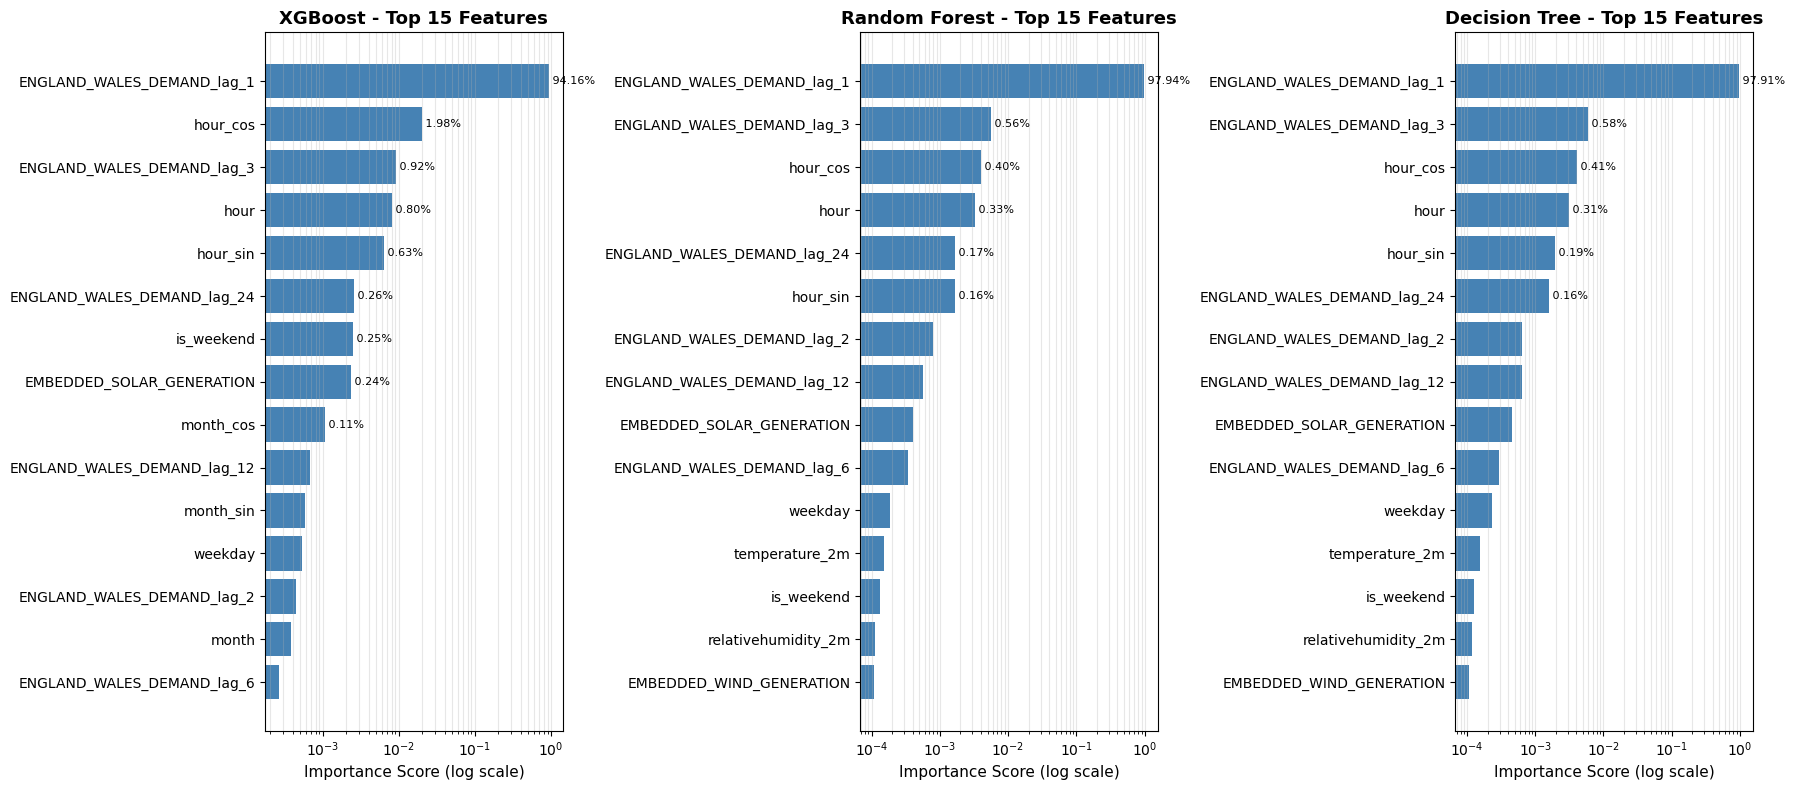


  Linear/NN models - correlation analysis:

FEATURE CORRELATION ANALYSIS

Top 20 features by absolute correlation with target:
ENGLAND_WALES_DEMAND_lag_1     0.989013
ENGLAND_WALES_DEMAND_lag_2     0.959449
ENGLAND_WALES_DEMAND_lag_3     0.914099
ENGLAND_WALES_DEMAND_lag_6     0.725879
month_cos                      0.518057
PUMP_STORAGE_PUMPING           0.477872
hour                           0.441899
hour_sin                       0.425688
ENGLAND_WALES_DEMAND_lag_12    0.366444
temperature_2m                 0.361310
hour_cos                       0.336825
BRITNED_FLOW                   0.268252
is_weekend                     0.238231
month_sin                      0.219014
NEMO_FLOW                      0.196047
weekday                        0.193043
ENGLAND_WALES_DEMAND_lag_24    0.176281
IFA_FLOW                       0.136658
VIKING_FLOW                    0.130605
EMBEDDED_SOLAR_GENERATION      0.102214

✓ Saved: correlation_heatmap_selected.png

[2/5] Analyzing feature corr

c:\Users\wenqi\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\wenqi\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



✓ Saved: correlation_heatmap_all.png

[3/5] Analyzing prediction errors...

PREDICTION ERROR ANALYSIS

✓ Saved: error_analysis.png

Error Statistics:
        Model  Mean_Error  Std_Error    Min_Error   Max_Error   Q25_Error  Q75_Error
      XGBoost   -4.513318 356.374779 -2499.262695 2605.535156 -212.472656 201.250000
Random Forest   -1.127078 357.759843 -2057.030000 1701.540000 -215.780000 206.730000
 Temporal CNN  108.150375 313.063189 -1766.083984 1588.824219  -88.023438 300.847656
          MLP  118.214955 317.434322 -1812.287109 1708.083984  -85.261719 309.167969

[4/5] Analyzing temporal error patterns...

TEMPORAL ERROR PATTERN ANALYSIS

✓ Saved: temporal_error_patterns.png

[5/5] Model performance comparison...

Model Performance Comparison:
            Model       R2       RMSE        MAE     MAPE
     Temporal CNN 0.996296 331.207368 255.818832 0.011229
              MLP 0.996127 338.721689 262.465851 0.011452
          XGBoost 0.995712 356.391090 266.902679 0.011910
    Ran

In [45]:
# ========================================================================
# PATTERN ANALYSIS - ADAPTIVE PIPELINE RESULTS
# ========================================================================

# Quick fix: Calculate samples dropped
original_test_len = len(test_df)
actual_test_len = len(data_adaptive['y_test'])
samples_dropped = original_test_len - actual_test_len

print(f"Original test samples: {original_test_len}")
print(f"After preprocessing: {actual_test_len}")
print(f"Samples dropped (from lag features): {samples_dropped}")

test_timestamps_aligned = test_df['datetime'].iloc[-len(data_adaptive['y_test']):].values

analysis_results_adaptive = run_complete_pattern_analysis_adaptive(
    X_train_all=data_adaptive['X_train_all'],
    X_train_selected=data_adaptive['X_train_selected'],
    y_train=data_adaptive['y_train'],
    y_test=data_adaptive['y_test'],
    predictions_dict=preds_adaptive,
    models_dict=models_adaptive,
    test_timestamps=test_timestamps_aligned,
    feature_cols_all=data_adaptive['feature_cols_all'],
    feature_cols_selected=data_adaptive['selected_features']
)

## E. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [54]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [55]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units = hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None

    def fit(self, X, y):
        # Initialize MLP with correct input_dim (not input_shape)
        self.mlp_instance = MLP(
            input_dim=X.shape[1],
            hidden_units=self.hidden_units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.mlp_instance.fit(X, y, verbose=0)
        return self

    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        return self.mlp_instance.predict(X)


class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=32, epochs=50, batch_size=32):
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None

    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])

        self.lstm_instance = LSTM_Model(
            input_shape=input_shape,
            units=self.units,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.lstm_instance.fit(X_lstm, y, verbose=0)
        return self

    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        return self.lstm_instance.predict(X_lstm)


class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self, filters=16, epochs=50, batch_size=32):
        self.filters = filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None

    def fit(self, X, y):
        # Reshape to (samples, timesteps=1, features)
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])

        self.cnn_instance = TemporalCNN(
            input_shape=input_shape,
            filters=self.filters,
            epochs=self.epochs,
            batch_size=self.batch_size
        )
        # Use separate fit method
        self.cnn_instance.fit(X_cnn, y, verbose=0)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        return self.cnn_instance.predict(X_cnn)

In [56]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}


✓ Linear Models - Training subset: (10519, 30)
✓ Linear Models - Validation subset: (24545, 30)
✓ Using SELECTED features (K=30)

Training Linear Regression with selected features...

Training Ridge Regression with selected features...

Training Linear SVR with selected features...

✓ Tree Models - Training subset: (10519, 41)
✓ Tree Models - Validation subset: (24545, 41)
✓ Using ALL features (K=41)

Training Decision Tree with all features...

Training Random Forest with all features...

Training XGBoost with all features...

ML MODELS - Complexity Analysis (Adaptive Features):
                Model   Feature_Config      Complexity   Train error  \
0   Linear Regression  Selected (K=30)        degree=1  3.695653e-03   
1   Linear Regression  Selected (K=30)        degree=2  1.920944e-03   
2   Linear Regression  Selected (K=30)        degree=3  5.726737e-04   
3    Ridge Regression  Selected (K=30)     alpha=1e-05  3.695653e-03   
4    Ridge Regression  Selected (K=30)    alpha=0.000

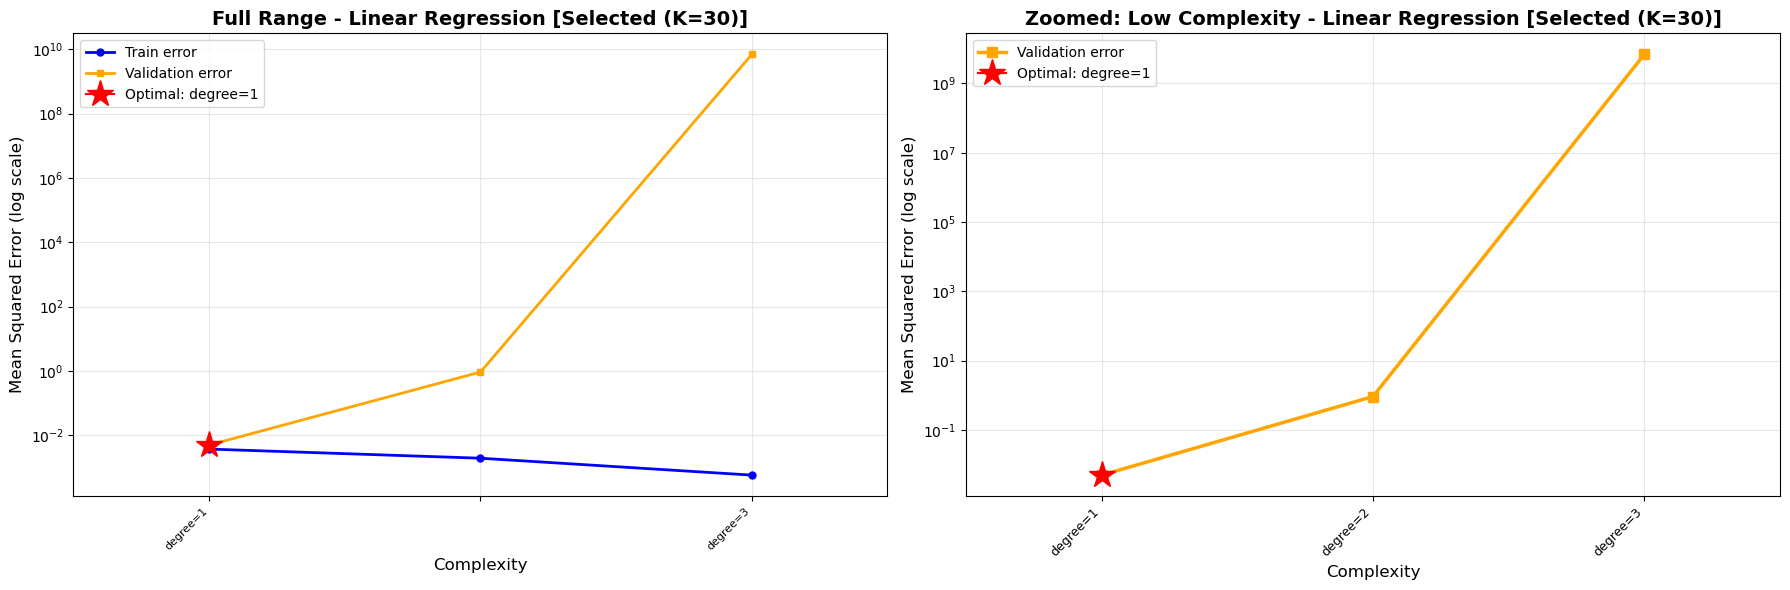

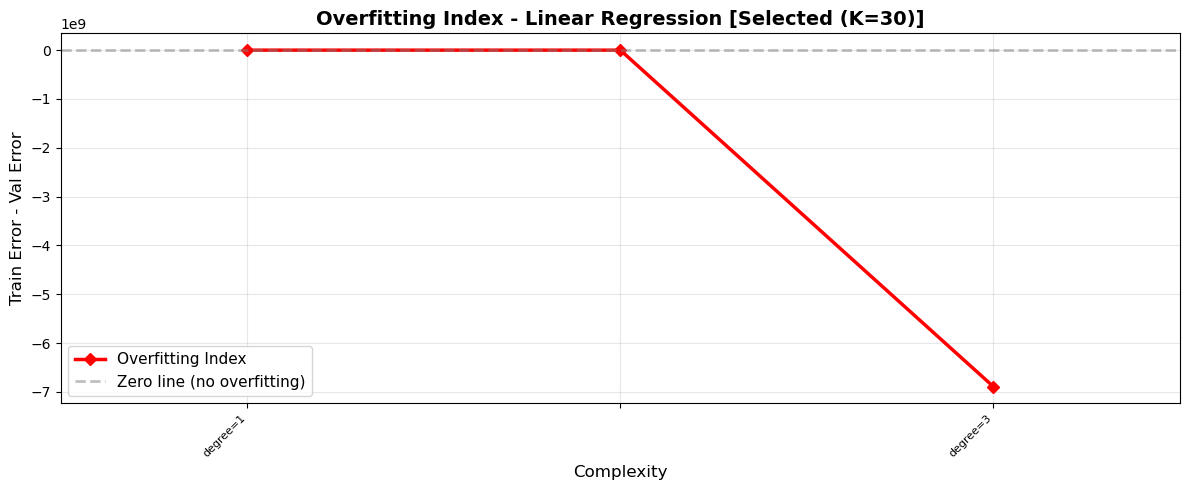


Linear Regression Analysis [Selected (K=30)]:
  Feature configuration: Selected (K=30)
  Lowest complexity tested: degree=1
    Train Error: 0.003696
    Val Error: 0.004940
  Optimal configuration: degree=1
    Train Error: 0.003696
    Val Error: 0.004940
  Highest complexity tested: degree=3
    Train Error: 0.000573
    Val Error: 6894317500.790777
    Overfitting Index: -6894317500.790205
  U-shape detected: YES


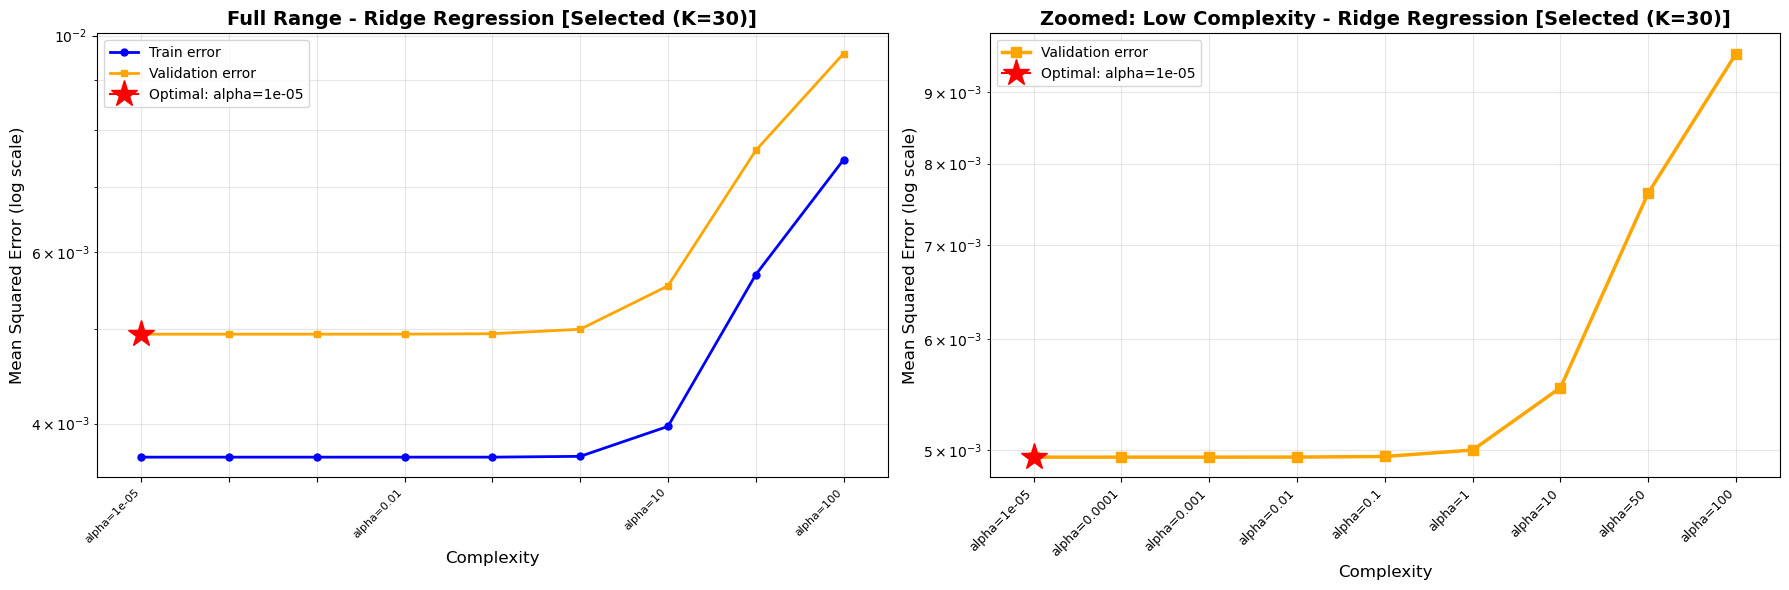

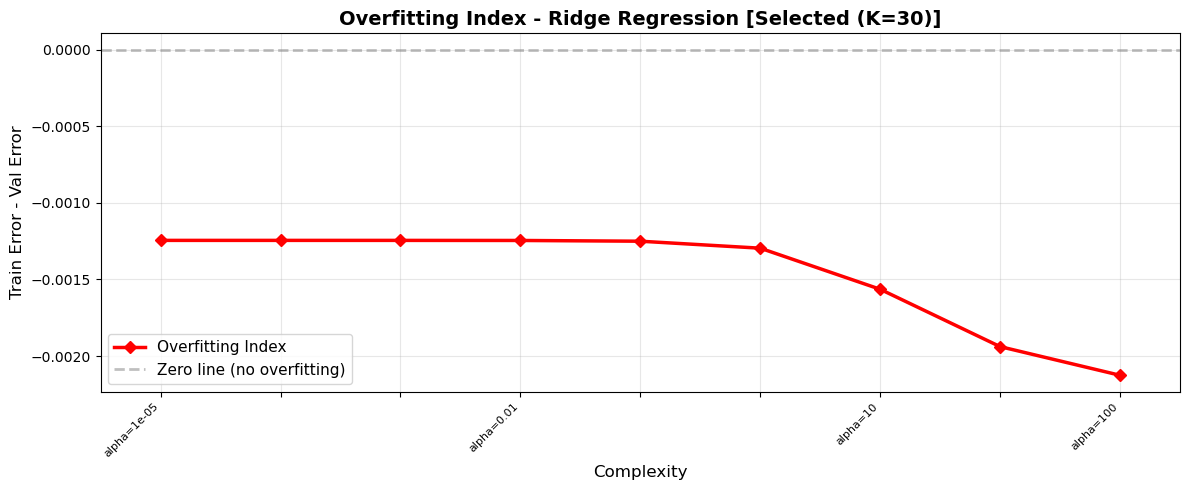


Ridge Regression Analysis [Selected (K=30)]:
  Feature configuration: Selected (K=30)
  Lowest complexity tested: alpha=1e-05
    Train Error: 0.003696
    Val Error: 0.004940
  Optimal configuration: alpha=1e-05
    Train Error: 0.003696
    Val Error: 0.004940
  Highest complexity tested: alpha=100
    Train Error: 0.007460
    Val Error: 0.009585
    Overfitting Index: -0.002125
  U-shape detected: YES


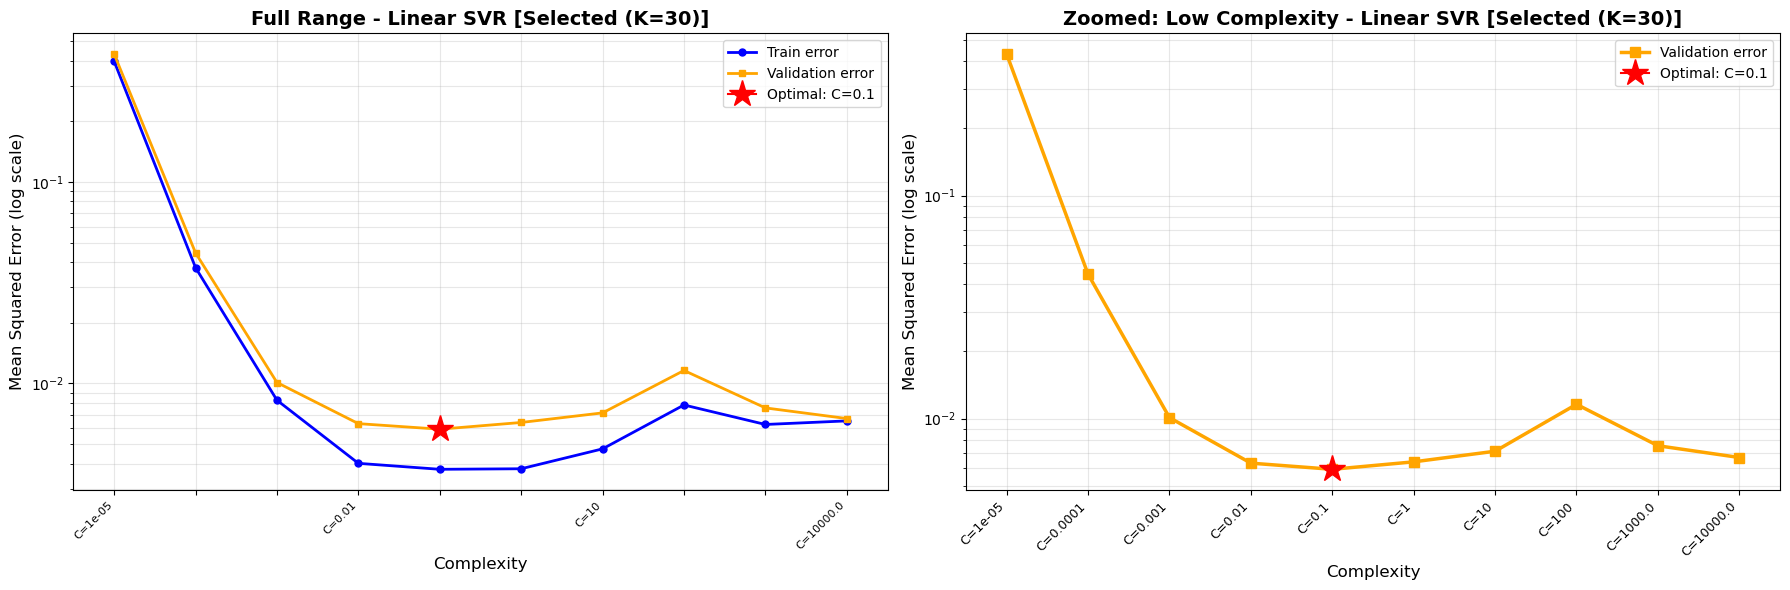

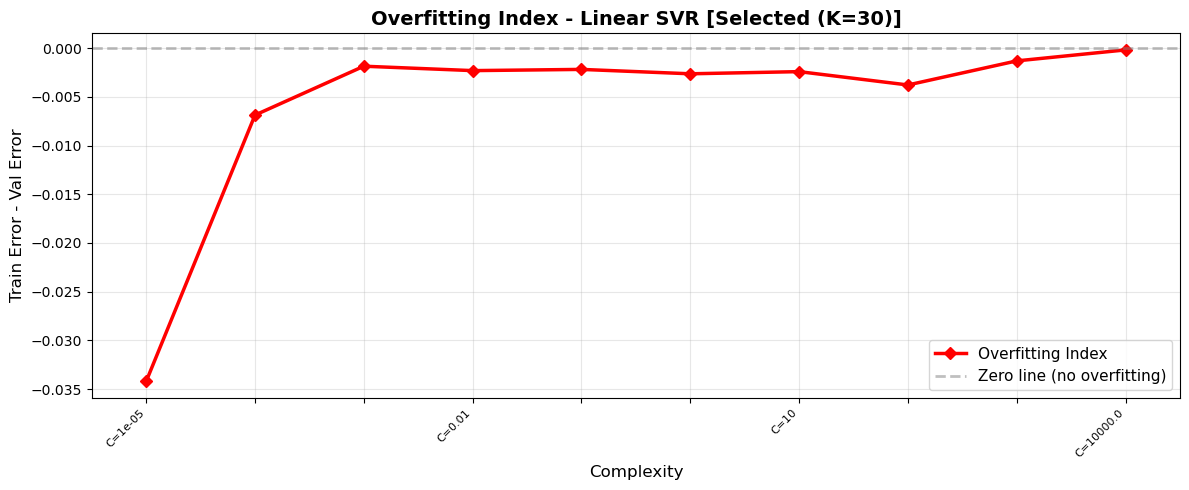


Linear SVR Analysis [Selected (K=30)]:
  Feature configuration: Selected (K=30)
  Lowest complexity tested: C=1e-05
    Train Error: 0.396196
    Val Error: 0.430401
  Optimal configuration: C=0.1
    Train Error: 0.003750
    Val Error: 0.005929
  Highest complexity tested: C=10000.0
    Train Error: 0.006519
    Val Error: 0.006696
    Overfitting Index: -0.000177
  U-shape detected: YES


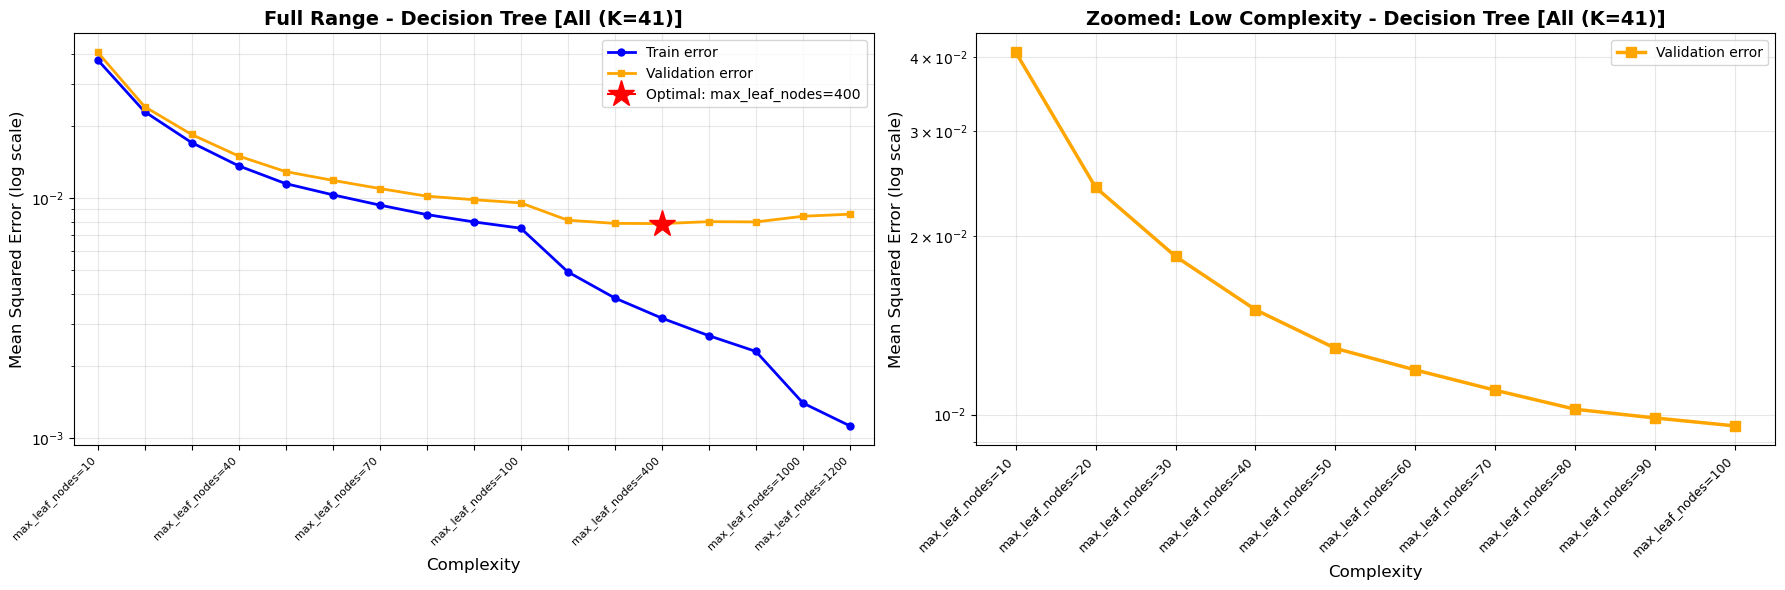

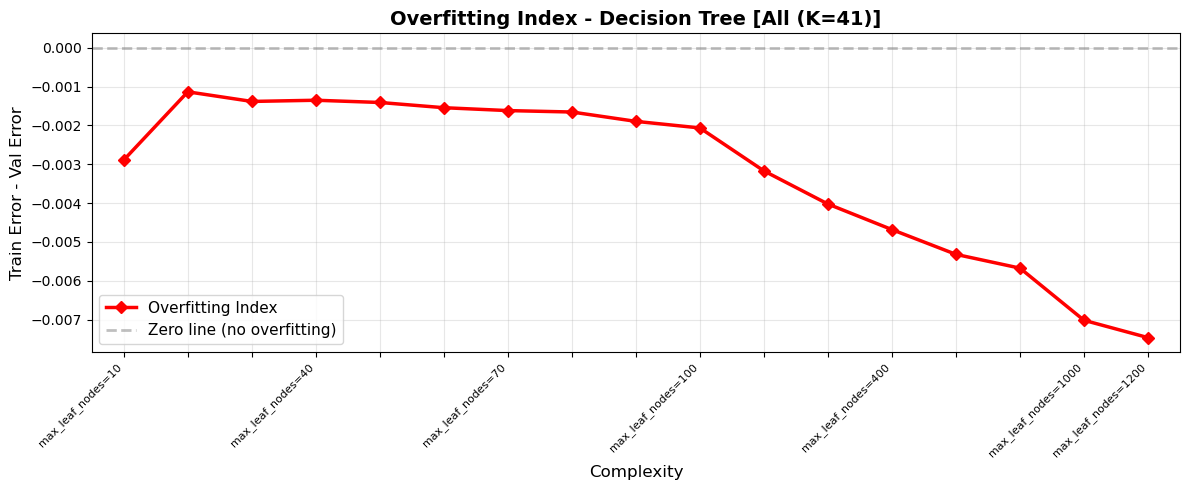


Decision Tree Analysis [All (K=41)]:
  Feature configuration: All (K=41)
  Lowest complexity tested: max_leaf_nodes=10
    Train Error: 0.037887
    Val Error: 0.040776
  Optimal configuration: max_leaf_nodes=400
    Train Error: 0.003162
    Val Error: 0.007844
  Highest complexity tested: max_leaf_nodes=1200
    Train Error: 0.001123
    Val Error: 0.008588
    Overfitting Index: -0.007465
  U-shape detected: PARTIAL


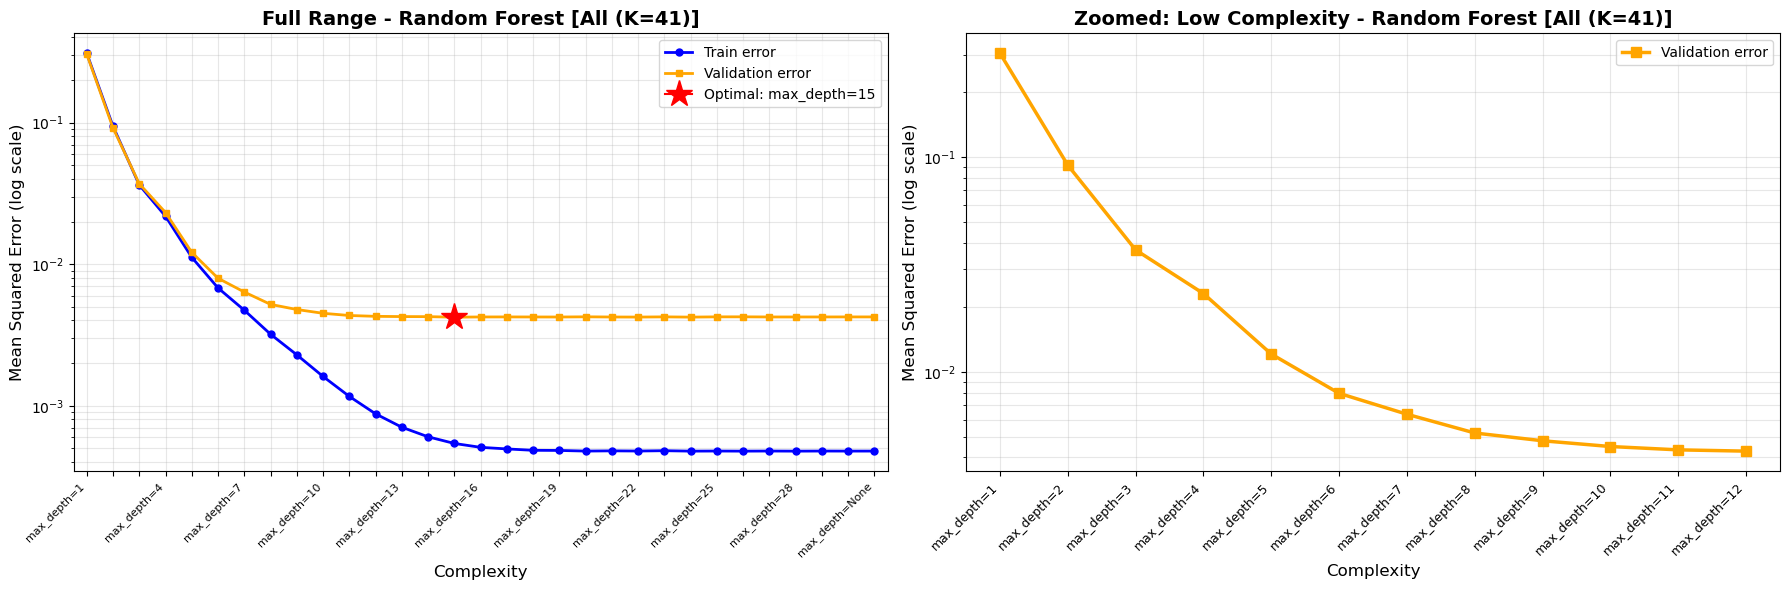

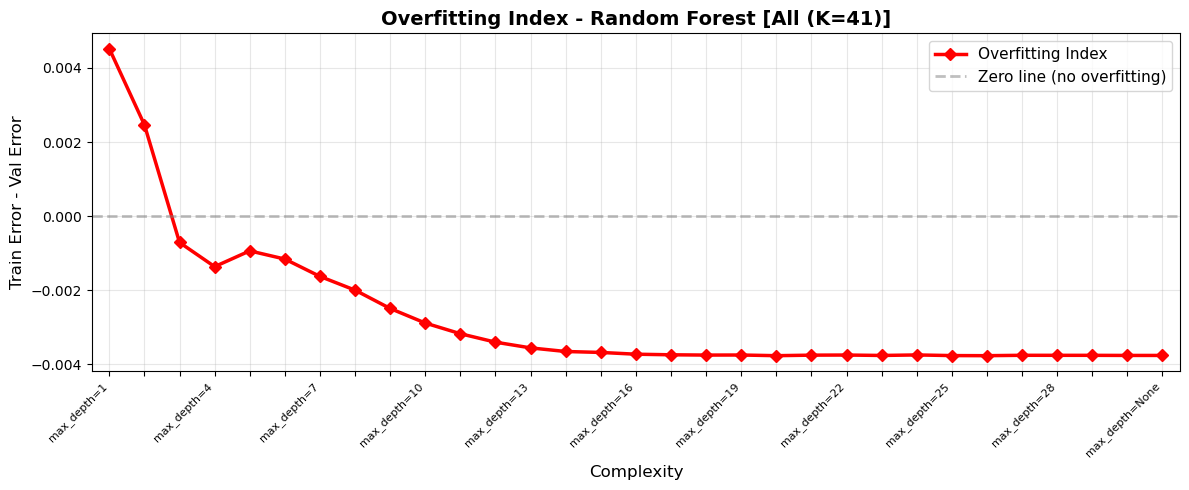


Random Forest Analysis [All (K=41)]:
  Feature configuration: All (K=41)
  Lowest complexity tested: max_depth=1
    Train Error: 0.308884
    Val Error: 0.304365
  Optimal configuration: max_depth=15
    Train Error: 0.000541
    Val Error: 0.004221
  Highest complexity tested: max_depth=None
    Train Error: 0.000478
    Val Error: 0.004239
    Overfitting Index: -0.003761
  U-shape detected: PARTIAL


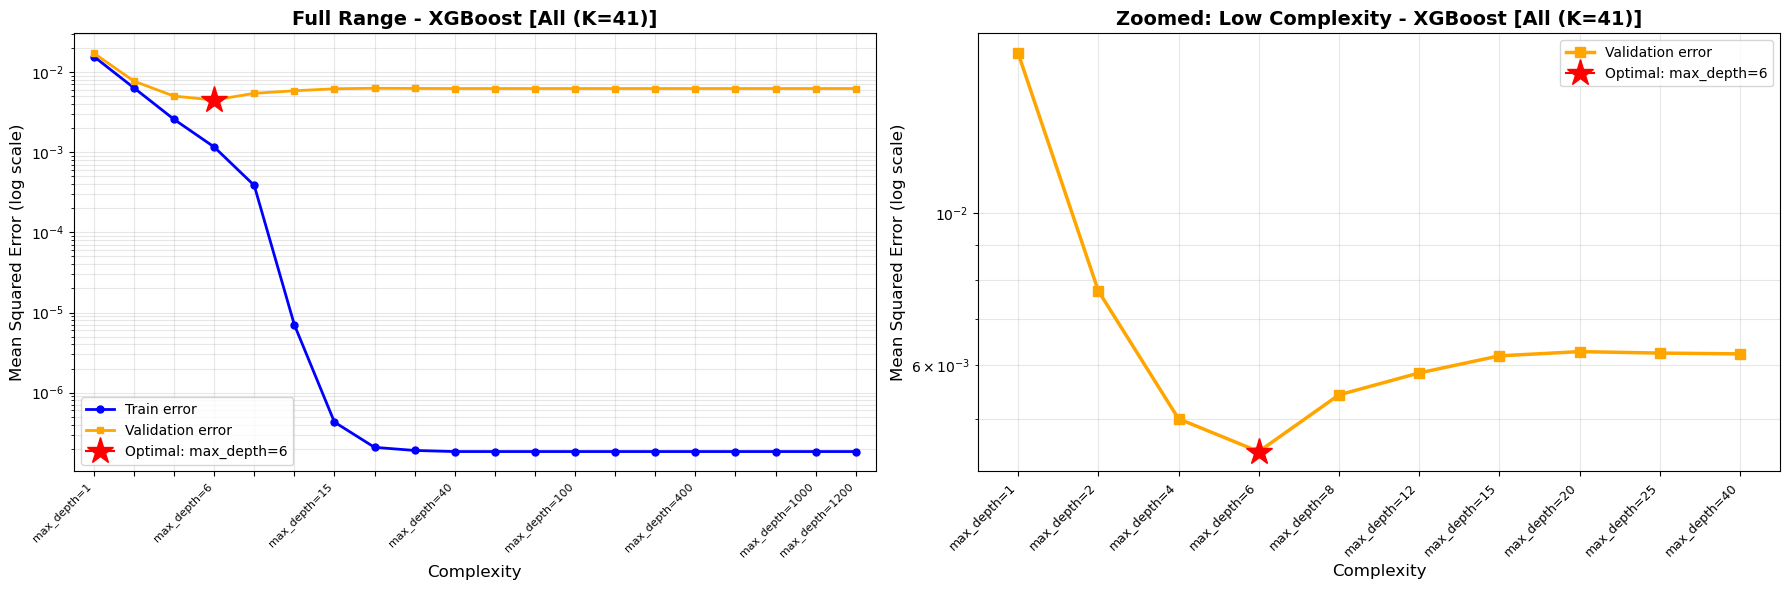

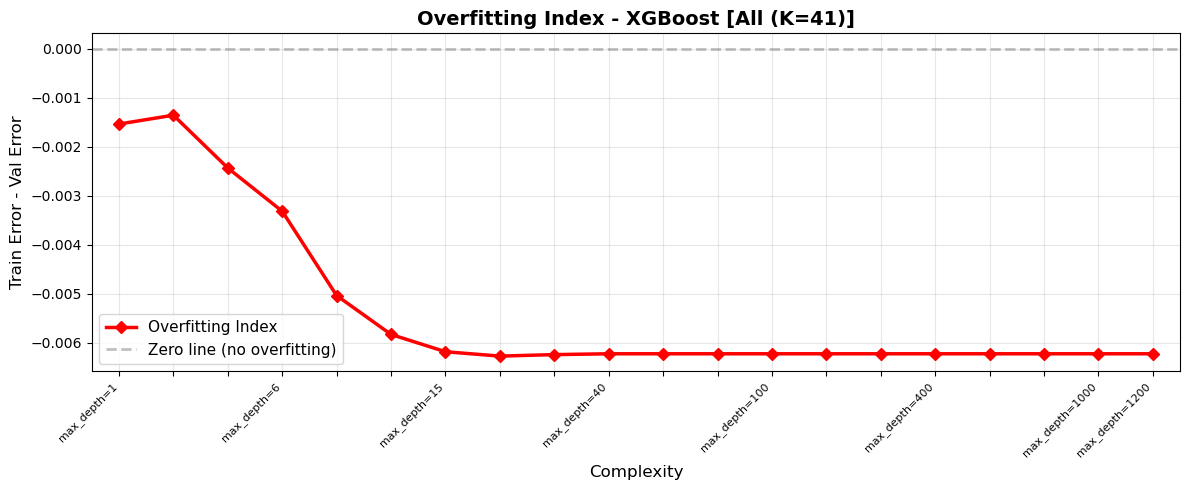


XGBoost Analysis [All (K=41)]:
  Feature configuration: All (K=41)
  Lowest complexity tested: max_depth=1
    Train Error: 0.015619
    Val Error: 0.017157
  Optimal configuration: max_depth=6
    Train Error: 0.001162
    Val Error: 0.004480
  Highest complexity tested: max_depth=1200
    Train Error: 0.000000
    Val Error: 0.006227
    Overfitting Index: -0.006227
  U-shape detected: YES

✓ ML complexity analysis complete (adaptive features)!


In [57]:
from sklearn.preprocessing import PolynomialFeatures

# ========================================================================
# COMPLEXITY ANALYSIS - LINEAR MODELS (with selected features)
# ========================================================================

subsample_ratio = 0.3
N = int(len(data_adaptive['X_train_selected_scaled']) * subsample_ratio)

# Linear models use SELECTED features (K=30)
X_tr_sub_scaled_selected  = data_adaptive['X_train_selected_scaled'][:N].copy()
y_tr_sub_scaled  = data_adaptive['y_train_scaled'][:N].copy()
X_val_sub_scaled_selected = data_adaptive['X_train_selected_scaled'][N:].copy()
y_val_sub_scaled = data_adaptive['y_train_scaled'][N:].copy()

print(f"✓ Linear Models - Training subset: {X_tr_sub_scaled_selected.shape}")
print(f"✓ Linear Models - Validation subset: {X_val_sub_scaled_selected.shape}")
print(f"✓ Using SELECTED features (K=30)")

# Run complexity analysis for linear models
ml_model_configs_linear = {
    "Linear Regression": {"degree": list(range(1, 4))},
    "Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},
    "Linear SVR": {"C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]},
}

ml_complexity_rows_linear = []

for model_name, param_dict in ml_model_configs_linear.items():
    print(f"\nTraining {model_name} with selected features...")
    for param_name, values in param_dict.items():
        for val in values:
            # Use SELECTED features for linear models
            X_sub = X_tr_sub_scaled_selected
            y_sub = y_tr_sub_scaled
            X_val_sub_local = X_val_sub_scaled_selected
            y_val_sub_local = y_val_sub_scaled

            if model_name == "Linear Regression":
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows_linear.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err,
                    "Feature_Config": "Selected (K=30)"
                })
                continue

            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)

            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))

            ml_complexity_rows_linear.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err,
                "Feature_Config": "Selected (K=30)"
            })

ml_cm_df_linear = pd.DataFrame(ml_complexity_rows_linear)
ml_cm_df_linear["Complexity Level"] = ml_cm_df_linear.groupby("Model").cumcount() + 1

# ========================================================================
# COMPLEXITY ANALYSIS - TREE-BASED MODELS (with all features)
# ========================================================================

N = int(len(data_adaptive['X_train_all_scaled']) * subsample_ratio)

# Tree-based models use ALL features (K=41)
X_tr_sub_scaled_all  = data_adaptive['X_train_all_scaled'][:N].copy()
X_val_sub_scaled_all = data_adaptive['X_train_all_scaled'][N:].copy()

print(f"\n✓ Tree Models - Training subset: {X_tr_sub_scaled_all.shape}")
print(f"✓ Tree Models - Validation subset: {X_val_sub_scaled_all.shape}")
print(f"✓ Using ALL features (K=41)")

ml_model_configs_tree = {
    "Decision Tree": {"max_leaf_nodes": [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,1000,1200]},
    "Random Forest": {"max_depth": list(range(1, 31)) + [None]},
    "XGBoost": {"max_depth":[1,2,4,6,8,12,15,20,25,40,60,80,100,150,200,400,600,800,1000,1200]}
}

ml_complexity_rows_tree = []

for model_name, param_dict in ml_model_configs_tree.items():
    print(f"\nTraining {model_name} with all features...")
    for param_name, values in param_dict.items():
        for val in values:
            # Use ALL features for tree-based models
            X_sub = X_tr_sub_scaled_all
            y_sub = y_tr_sub_scaled
            X_val_sub_local = X_val_sub_scaled_all
            y_val_sub_local = y_val_sub_scaled

            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_leaf_nodes=val, random_state=42)
            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42, n_jobs=-1)
            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42,
                    n_jobs=-1
                )

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))

            ml_complexity_rows_tree.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err,
                "Feature_Config": "All (K=41)"
            })

ml_cm_df_tree = pd.DataFrame(ml_complexity_rows_tree)
ml_cm_df_tree["Complexity Level"] = ml_cm_df_tree.groupby("Model").cumcount() + 1

# ========================================================================
# COMBINE RESULTS
# ========================================================================

ml_cm_df = pd.concat([ml_cm_df_linear, ml_cm_df_tree], ignore_index=True)

print("\n" + "="*80)
print("ML MODELS - Complexity Analysis (Adaptive Features):")
print("="*80)
print(ml_cm_df[['Model', 'Feature_Config', 'Complexity', 'Train error', 'Val error']])

# ========================================================================
# PLOTTING - ML MODELS (Adaptive Features)
# ========================================================================

print("\nGenerating plots for ML models (adaptive features)...")

for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]
    feature_config = temp.iloc[0]['Feature_Config']  # Get feature config for this model

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"],
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"],
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')

    # Mark optimal point
    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20,
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    # Adjust x-axis labels
    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else ''
                   for i, label in enumerate(tick_labels)]

    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model} [{feature_config}]", fontsize=14, fontweight='bold')  # ← 加feature config
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')

    # Right plot: Zoomed into low complexity
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]

    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"],
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')

    # Mark optimal if in zoom range
    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20,
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity - {model} [{feature_config}]", fontsize=14, fontweight='bold')  # ← 加feature config
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.savefig(f'complexity_analysis_{model.replace(" ", "_")}_adaptive.png', dpi=300, bbox_inches='tight')  # ← Save with new name
    plt.show()

    # Overfitting Index plot
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"],
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line (no overfitting)')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model} [{feature_config}]", fontsize=14, fontweight='bold')  # ← 加feature config
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'overfitting_index_{model.replace(" ", "_")}_adaptive.png', dpi=300, bbox_inches='tight')  # ← Save with new name
    plt.show()

    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis [{feature_config}]:")  # ← 加feature config
    print(f"{'='*60}")
    print(f"  Feature configuration: {feature_config}")
    print(f"  Lowest complexity tested: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal configuration: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity tested: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape detected: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ ML complexity analysis complete (adaptive features)!")
print("="*80)


PART A: SVR OPTIMAL CONFIGURATION

SVR Complexity Analysis Results (from Part A):
Complexity  Train error  Val error  Overfitting Index
   C=1e-05     0.396196   0.430401          -0.034205
  C=0.0001     0.037516   0.044383          -0.006867
   C=0.001     0.008254   0.010105          -0.001851
    C=0.01     0.004014   0.006318          -0.002303
     C=0.1     0.003750   0.005929          -0.002179
       C=1     0.003773   0.006402          -0.002629
      C=10     0.004736   0.007144          -0.002408
     C=100     0.007819   0.011596          -0.003777
  C=1000.0     0.006257   0.007561          -0.001304
 C=10000.0     0.006519   0.006696          -0.000177

OPTIMAL SVR CONFIGURATION FROM PART A:
  Configuration: C=0.1
  C value: 0.1
  Train error: 0.003750
  Val error: 0.005929
  Overfitting Index: -0.002179


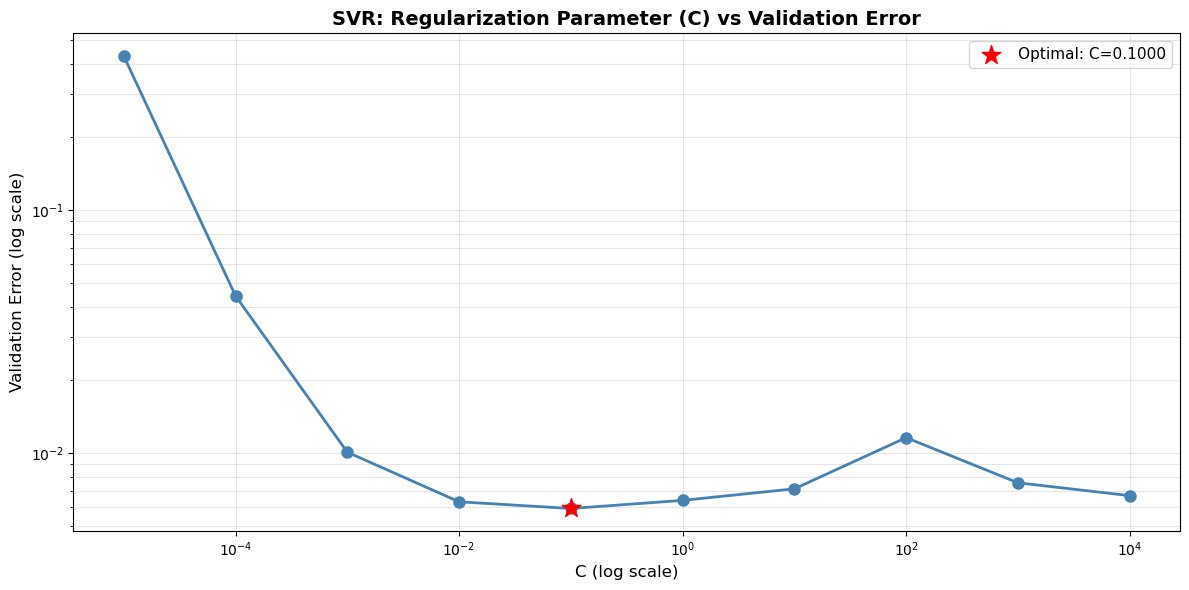


✓ Saved: svr_C_selection_partA.png


In [58]:
# ========================================================================
# EXTRACT PART A SVR OPTIMAL C VALUE
# ========================================================================

print("\n" + "="*80)
print("PART A: SVR OPTIMAL CONFIGURATION")
print("="*80)

# Filter SVR results from ml_cm_df
svr_complexity = ml_cm_df[ml_cm_df['Model'] == 'Linear SVR'].copy()

print("\nSVR Complexity Analysis Results (from Part A):")
print(svr_complexity[['Complexity', 'Train error', 'Val error', 'Overfitting Index']].to_string(index=False))

# Find optimal C (minimum validation error)
optimal_idx = svr_complexity['Val error'].idxmin()
optimal_complexity = svr_complexity.loc[optimal_idx, 'Complexity']
optimal_train_err = svr_complexity.loc[optimal_idx, 'Train error']
optimal_val_err = svr_complexity.loc[optimal_idx, 'Val error']

# Extract C value from "C=X.X" string
optimal_C = float(optimal_complexity.split('=')[1])

print("\n" + "="*80)
print("OPTIMAL SVR CONFIGURATION FROM PART A:")
print("="*80)
print(f"  Configuration: {optimal_complexity}")
print(f"  C value: {optimal_C}")
print(f"  Train error: {optimal_train_err:.6f}")
print(f"  Val error: {optimal_val_err:.6f}")
print(f"  Overfitting Index: {svr_complexity.loc[optimal_idx, 'Overfitting Index']:.6f}")

# Also check C=1.0 for comparison
c1_rows = svr_complexity[svr_complexity['Complexity'] == 'C=1.0']
if not c1_rows.empty:
    c1_val_err = c1_rows.iloc[0]['Val error']
    print(f"\nC=1.0 (default) performance in Part A:")
    print(f"  Val error: {c1_val_err:.6f}")
    print(f"  Difference from optimal: {c1_val_err - optimal_val_err:+.6f}")

# Visualize C vs Validation Error
plt.figure(figsize=(12, 6))

# Extract C values and errors
C_values = []
val_errors = []
for _, row in svr_complexity.iterrows():
    C_val = float(row['Complexity'].split('=')[1])
    C_values.append(C_val)
    val_errors.append(row['Val error'])

plt.plot(C_values, val_errors, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
plt.scatter([optimal_C], [optimal_val_err], color='red', s=200, marker='*', zorder=5,
           label=f'Optimal: C={optimal_C:.4f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('C (log scale)', fontsize=12)
plt.ylabel('Validation Error (log scale)', fontsize=12)
plt.title('SVR: Regularization Parameter (C) vs Validation Error', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('svr_C_selection_partA.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: svr_C_selection_partA.png")

In [59]:
def get_epochs_for_complexity(complexity_level, total_levels):
    """
    Much more aggressive epoch scheduling to force overfitting
    """
    progress = complexity_level / total_levels

    if progress < 0.2:
        return 10   # Simple models - minimal training
    elif progress < 0.5:
        return 30   # Medium models
    else:
        return 100  # ← High complexity models MUST overfit with this many epochs

In [60]:
# ========================================================================
# COMPLEXITY ANALYSIS - NEURAL NETWORKS (Adaptive Features)
# ========================================================================

# Prepare data for both feature sets
subsample_ratio = 0.3
N = int(len(data_adaptive['X_train_all_scaled']) * subsample_ratio)

# Neural networks: MLP & CNN use SELECTED features, LSTM uses ALL features
X_tr_sub_scaled_selected  = data_adaptive['X_train_selected_scaled'][:N].copy()
X_val_sub_scaled_selected = data_adaptive['X_train_selected_scaled'][N:].copy()

X_tr_sub_scaled_all  = data_adaptive['X_train_all_scaled'][:N].copy()
X_val_sub_scaled_all = data_adaptive['X_train_all_scaled'][N:].copy()

y_tr_sub_scaled  = data_adaptive['y_train_scaled'][:N].copy()
y_val_sub_scaled = data_adaptive['y_train_scaled'][N:].copy()

print(f"\n✓ Neural Networks - Training subset:")
print(f"  Selected features (K=30): {X_tr_sub_scaled_selected.shape}")
print(f"  All features (K=41): {X_tr_sub_scaled_all.shape}")
print(f"  Validation subset:")
print(f"  Selected features (K=30): {X_val_sub_scaled_selected.shape}")
print(f"  All features (K=41): {X_val_sub_scaled_all.shape}")

nn_model_configs = {
    # MLP: Start from 1 hidden unit
    "MLP": {"hidden_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                        128, 160, 192, 256, 320, 384, 512, 768, 1024,
                        1536, 2048, 3072, 4096] },

    # LSTM: Start from 1 unit
    "LSTM": {"lstm_units": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                      128, 160, 192, 256, 320, 384, 512,768,1024,2048,4096]},

    # Temporal CNN: Start from 1 filter
    "Temporal CNN": {"filters": [1, 2, 3, 4, 6, 8, 12, 16, 20, 24, 32, 40, 48, 64, 80, 96,
                   128, 160, 192, 256, 384, 512, 768, 1024,2048,4096]}
}

nn_complexity_rows = []

for model_name, param_dict in nn_model_configs.items():
    print(f"\nTraining {model_name}...")

    # Determine which feature set to use
    if model_name == "LSTM":
        X_train_model = X_tr_sub_scaled_all
        X_val_model = X_val_sub_scaled_all
        feature_config = "All (K=41)"
        print(f"  Using ALL features (K=41)")
    else:
        X_train_model = X_tr_sub_scaled_selected
        X_val_model = X_val_sub_scaled_selected
        feature_config = "Selected (K=30)"
        print(f"  Using SELECTED features (K=30)")

    for param_name, values in param_dict.items():
        for i, val in enumerate(values, 1):
            print(f"  Progress: {i}/{len(values)} - {param_name}={val}")

            X_sub = X_train_model
            y_sub = y_tr_sub_scaled
            X_val_sub_local = X_val_model
            y_val_sub_local = y_val_sub_scaled

            epochs = 10

            if model_name == "MLP":
                model = MLP_Wrapper(hidden_units=val, epochs=epochs)
            elif model_name == "LSTM":
                model = LSTM_Wrapper(units=val, epochs=epochs)
            elif model_name == "Temporal CNN":
                model = TemporalCNN_Wrapper(filters=val, epochs=epochs)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))

            nn_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err,
                "Feature_Config": feature_config
            })

nn_cm_df = pd.DataFrame(nn_complexity_rows)
nn_cm_df["Complexity Level"] = nn_cm_df.groupby("Model").cumcount() + 1

# Save
nn_cm_df.to_csv('nn_complexity_adaptive_results.csv', index=False)
print("\n✓ Results saved to 'nn_complexity_adaptive_results.csv'")

print("\n" + "="*80)
print("NN MODELS - Complexity Analysis (Adaptive Features):")
print("="*80)
print(nn_cm_df[['Model', 'Feature_Config', 'Complexity', 'Train error', 'Val error']].head(30))

# ========================================================================
# PLOTTING - NEURAL NETWORKS (Adaptive Features)
# ========================================================================

print("\nGenerating plots for neural networks (adaptive features)...")

for model in nn_cm_df["Model"].unique():
    temp = nn_cm_df[nn_cm_df["Model"] == model]
    feature_config = temp.iloc[0]['Feature_Config']  # Get feature config for this model

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Left plot: Full range
    ax1.plot(temp["Complexity Level"], temp["Train error"],
            marker='o', linestyle='-', linewidth=2, markersize=5, label='Train error', color='blue')
    ax1.plot(temp["Complexity Level"], temp["Val error"],
            marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation error', color='orange')

    optimal_idx = temp["Val error"].idxmin()
    optimal_level = temp.loc[optimal_idx, "Complexity Level"]
    optimal_val = temp.loc[optimal_idx, "Val error"]
    ax1.plot(optimal_level, optimal_val, marker='*', markersize=20,
            color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    tick_positions = temp["Complexity Level"].values
    tick_labels = temp["Complexity"].values
    show_labels = [label if i % 3 == 0 or i == len(tick_labels)-1 else ''
                   for i, label in enumerate(tick_labels)]

    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(show_labels, rotation=45, ha='right', fontsize=8)
    ax1.set_xlim(0.5, temp["Complexity Level"].max() + 0.5)
    ax1.set_yscale('log')
    ax1.set_title(f"Full Range - {model} [{feature_config}]", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Complexity", fontsize=12)
    ax1.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3, which='both')

    # Right plot: Zoomed
    zoom_point = max(10, int(len(temp) * 0.4))
    temp_zoom = temp.iloc[:zoom_point]

    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Train error"],
            marker='o', linestyle='-', linewidth=2.5, markersize=7, label='Train error', color='blue')
    ax2.plot(temp_zoom["Complexity Level"], temp_zoom["Val error"],
            marker='s', linestyle='-', linewidth=2.5, markersize=7, label='Validation error', color='orange')

    if optimal_level <= zoom_point:
        ax2.plot(optimal_level, optimal_val, marker='*', markersize=20,
                color='red', label=f'Optimal: {temp.loc[optimal_idx, "Complexity"]}', zorder=5)

    ax2.set_xticks(temp_zoom["Complexity Level"])
    ax2.set_xticklabels(temp_zoom["Complexity"], rotation=45, ha='right', fontsize=9)
    ax2.set_xlim(0.5, temp_zoom["Complexity Level"].max() + 0.5)
    ax2.set_yscale('log')
    ax2.set_title(f"Zoomed: Low Complexity - {model} [{feature_config}]", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Complexity", fontsize=12)
    ax2.set_ylabel("Mean Squared Error (log scale)", fontsize=12)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.savefig(f'complexity_analysis_{model.replace(" ", "_")}_adaptive.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Overfitting Index
    plt.figure(figsize=(12, 5))
    plt.plot(temp["Complexity Level"], temp["Overfitting Index"],
             marker='D', linestyle='-', linewidth=2.5, markersize=6, color='red', label='Overfitting Index')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Zero line')
    plt.xticks(tick_positions, show_labels, rotation=45, ha='right', fontsize=8)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.title(f"Overfitting Index - {model} [{feature_config}]", fontsize=14, fontweight='bold')
    plt.xlabel("Complexity", fontsize=12)
    plt.ylabel("Train Error - Val Error", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'overfitting_index_{model.replace(" ", "_")}_adaptive.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print analysis
    print(f"\n{'='*60}")
    print(f"{model} Analysis [{feature_config}]:")
    print(f"{'='*60}")
    print(f"  Feature configuration: {feature_config}")
    print(f"  Lowest complexity: {temp.iloc[0]['Complexity']}")
    print(f"    Train Error: {temp.iloc[0]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[0]['Val error']:.6f}")
    print(f"  Optimal: {temp.loc[optimal_idx, 'Complexity']}")
    print(f"    Train Error: {temp.loc[optimal_idx, 'Train error']:.6f}")
    print(f"    Val Error: {optimal_val:.6f}")
    print(f"  Highest complexity: {temp.iloc[-1]['Complexity']}")
    print(f"    Train Error: {temp.iloc[-1]['Train error']:.6f}")
    print(f"    Val Error: {temp.iloc[-1]['Val error']:.6f}")
    print(f"    Overfitting Index: {temp.iloc[-1]['Overfitting Index']:.6f}")
    print(f"  U-shape: {'YES' if temp.iloc[-1]['Val error'] > optimal_val * 1.1 else 'PARTIAL'}")

print("\n" + "="*80)
print("✓ NN complexity analysis complete (adaptive features)!")
print("="*80)
print("\nKey insights:")
print("- MLP & Temporal CNN: Trained with K=30 selected features")
print("- LSTM: Trained with K=41 all features (sequences benefit from richer feature set)")
print("- If val error is HIGH at complexity=1-4: Clear underfitting (high bias)")
print("- If val error DECREASES then INCREASES: Classic U-shaped curve")
print("- If val error only DECREASES: Need even simpler models or less data")


✓ Neural Networks - Training subset:
  Selected features (K=30): (10519, 30)
  All features (K=41): (10519, 41)
  Validation subset:
  Selected features (K=30): (24545, 30)
  All features (K=41): (24545, 41)

Training MLP...
  Using SELECTED features (K=30)
  Progress: 1/29 - hidden_units=1
  Progress: 2/29 - hidden_units=2
  Progress: 3/29 - hidden_units=3
  Progress: 4/29 - hidden_units=4
  Progress: 5/29 - hidden_units=6
  Progress: 6/29 - hidden_units=8
  Progress: 7/29 - hidden_units=12
  Progress: 8/29 - hidden_units=16
  Progress: 9/29 - hidden_units=20
  Progress: 10/29 - hidden_units=24
  Progress: 11/29 - hidden_units=32
  Progress: 12/29 - hidden_units=40
  Progress: 13/29 - hidden_units=48
  Progress: 14/29 - hidden_units=64
  Progress: 15/29 - hidden_units=80
  Progress: 16/29 - hidden_units=96
  Progress: 17/29 - hidden_units=128
  Progress: 18/29 - hidden_units=160
  Progress: 19/29 - hidden_units=192
  Progress: 20/29 - hidden_units=256
  Progress: 21/29 - hidden_units

KeyboardInterrupt: 

## Select winner models

# Part B

## Additional preprocessing testing

In [61]:
def test_pca_preprocessing(data_adaptive, scalers_adaptive, n_components_list=[10, 15, 20, 25]):
    """
    Test different PCA components to see if dimensionality reduction helps.

    Args:
        data_adaptive: Your adaptive pipeline data dict
        scalers_adaptive: Scalers dict from adaptive pipeline
        n_components_list: Different PCA component counts to test

    Returns:
        results_df: Performance comparison
    """

    print("\n" + "="*80)
    print("OPTIONAL PREPROCESSING TEST: PCA")
    print("="*80)

    results_list = []

    # Baseline: No PCA (use selected K=30 features)
    print("\n[Baseline] Training without PCA (K=30 selected features)...")

    X_train = data_adaptive['X_train_selected_scaled']
    X_test = data_adaptive['X_test_selected_scaled']
    y_train = data_adaptive['y_train_scaled']
    y_test_original = data_adaptive['y_test']
    scaler_y = scalers_adaptive['scaler_y']  # ← From scalers_adaptive

    # Train a representative model (e.g., MLP)
    mlp_baseline = MLP(input_dim=X_train.shape[1], hidden_units=32, epochs=50, batch_size=32)
    mlp_baseline.fit(X_train, y_train, verbose=0)
    y_pred_scaled = mlp_baseline.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics_baseline = compute_metrics(y_test_original, y_pred)
    results_list.append({
        'Method': 'Baseline (No PCA)',
        'Components': 30,
        'R2': metrics_baseline['R2'],
        'RMSE': metrics_baseline['RMSE'],
        'MAE': metrics_baseline['MAE']
    })

    print(f"  Baseline: R²={metrics_baseline['R2']:.6f}, RMSE={metrics_baseline['RMSE']:.2f}")

    # Test different PCA components
    for n_comp in n_components_list:
        print(f"\n[PCA] Testing with {n_comp} components...")

        # Apply PCA
        from sklearn.decomposition import PCA
        pca = PCA(n_components=n_comp)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train MLP with PCA features
        mlp_pca = MLP(input_dim=n_comp, hidden_units=32, epochs=50, batch_size=32)
        mlp_pca.fit(X_train_pca, y_train, verbose=0)
        y_pred_scaled = mlp_pca.predict(X_test_pca)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        metrics_pca = compute_metrics(y_test_original, y_pred)

        # Calculate variance explained
        var_explained = pca.explained_variance_ratio_.sum()

        results_list.append({
            'Method': f'PCA ({n_comp} comp)',
            'Components': n_comp,
            'R2': metrics_pca['R2'],
            'RMSE': metrics_pca['RMSE'],
            'MAE': metrics_pca['MAE'],
            'Variance_Explained': var_explained
        })

        print(f"  PCA ({n_comp}): R²={metrics_pca['R2']:.6f}, RMSE={metrics_pca['RMSE']:.2f}, Var={var_explained:.4f}")

    results_df = pd.DataFrame(results_list)

    # Decision
    best_idx = results_df['R2'].idxmax()
    best_method = results_df.loc[best_idx, 'Method']
    baseline_r2 = results_df.loc[0, 'R2']
    best_r2 = results_df.loc[best_idx, 'R2']

    print("\n" + "="*80)
    print("PCA PREPROCESSING DECISION")
    print("="*80)
    print(f"Baseline (No PCA): R²={baseline_r2:.6f}")
    print(f"Best PCA config: {best_method}, R²={best_r2:.6f}")

    if best_r2 > baseline_r2 + 0.001:
        print(f"✓ RECOMMENDATION: Use {best_method}")
        print(f"  Improvement: +{best_r2 - baseline_r2:.6f}")
    else:
        print("✗ RECOMMENDATION: Do NOT use PCA")
        print("  PCA does not improve performance significantly")

    return results_df


def test_interaction_features(data_adaptive, scalers_adaptive):
    """
    Test if weather x time interactions improve performance.
    """

    print("\n" + "="*80)
    print("OPTIONAL PREPROCESSING TEST: INTERACTION FEATURES")
    print("="*80)

    results_list = []

    # Get data
    X_train_orig = data_adaptive['X_train_selected']  # Unscaled
    X_test_orig = data_adaptive['X_test_selected']
    y_train = data_adaptive['y_train']
    y_test = data_adaptive['y_test']

    # Baseline: No interactions
    print("\n[Baseline] No interaction features...")

    X_train_base = X_train_orig.copy()
    X_test_base = X_test_orig.copy()

    # Scale
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_base)
    X_test_scaled = scaler_X.transform(X_test_base)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Train
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = ridge.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics_baseline = compute_metrics(y_test, y_pred)
    results_list.append({
        'Method': 'Baseline',
        'Num_Features': X_train_base.shape[1],
        'R2': metrics_baseline['R2'],
        'RMSE': metrics_baseline['RMSE']
    })

    print(f"  Features: {X_train_base.shape[1]}, R²={metrics_baseline['R2']:.6f}")

    # Add interaction features
    print("\n[Interactions] Adding weather x time interactions...")

    X_train_int = X_train_orig.copy()
    X_test_int = X_test_orig.copy()

    interactions_added = 0

    # Temperature x Time interactions
    if 'temperature_2m' in X_train_int.columns and 'hour_sin' in X_train_int.columns:
        X_train_int['temp_x_hour_sin'] = X_train_int['temperature_2m'] * X_train_int['hour_sin']
        X_test_int['temp_x_hour_sin'] = X_test_int['temperature_2m'] * X_test_int['hour_sin']
        interactions_added += 1

    if 'temperature_2m' in X_train_int.columns and 'month_cos' in X_train_int.columns:
        X_train_int['temp_x_month_cos'] = X_train_int['temperature_2m'] * X_train_int['month_cos']
        X_test_int['temp_x_month_cos'] = X_test_int['temperature_2m'] * X_test_int['month_cos']
        interactions_added += 1

    # Solar x Time interaction
    if 'EMBEDDED_SOLAR_GENERATION' in X_train_int.columns and 'hour_cos' in X_train_int.columns:
        X_train_int['solar_x_hour_cos'] = X_train_int['EMBEDDED_SOLAR_GENERATION'] * X_train_int['hour_cos']
        X_test_int['solar_x_hour_cos'] = X_test_int['EMBEDDED_SOLAR_GENERATION'] * X_test_int['hour_cos']
        interactions_added += 1

    # Lag x Weekend interaction
    if 'ENGLAND_WALES_DEMAND_lag_1' in X_train_int.columns and 'is_weekend' in X_train_int.columns:
        X_train_int['lag1_x_weekend'] = X_train_int['ENGLAND_WALES_DEMAND_lag_1'] * X_train_int['is_weekend']
        X_test_int['lag1_x_weekend'] = X_test_int['ENGLAND_WALES_DEMAND_lag_1'] * X_test_int['is_weekend']
        interactions_added += 1

    print(f"  Created {interactions_added} interaction features")
    print(f"  Total features: {X_train_orig.shape[1]} → {X_train_int.shape[1]}")

    # Scale
    scaler_X_int = StandardScaler()
    X_train_int_scaled = scaler_X_int.fit_transform(X_train_int)
    X_test_int_scaled = scaler_X_int.transform(X_test_int)

    # Train
    ridge_int = Ridge(alpha=1.0)
    ridge_int.fit(X_train_int_scaled, y_train_scaled)
    y_pred_scaled = ridge_int.predict(X_test_int_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    metrics_int = compute_metrics(y_test, y_pred)
    results_list.append({
        'Method': 'With Interactions',
        'Num_Features': X_train_int.shape[1],
        'R2': metrics_int['R2'],
        'RMSE': metrics_int['RMSE']
    })

    print(f"  R²={metrics_int['R2']:.6f}, RMSE={metrics_int['RMSE']:.2f}")

    results_df = pd.DataFrame(results_list)

    # Decision
    print("\n" + "="*80)
    print("INTERACTION FEATURES DECISION")
    print("="*80)
    print(results_df.to_string(index=False))

    improvement = metrics_int['R2'] - metrics_baseline['R2']

    if improvement > 0.0005:
        print(f"\n✓ RECOMMENDATION: Use interaction features")
        print(f"  Improvement: +{improvement:.6f}")
    else:
        print("\n✗ RECOMMENDATION: Do NOT use interaction features")
        print(f"  Minimal improvement ({improvement:+.6f}), not worth added complexity")

    return results_df

In [62]:
# Experiment 1: PCA
pca_results = test_pca_preprocessing(
    data_adaptive,
    scalers_adaptive,
    n_components_list=[10, 15, 20, 25]
)

# Experiment 2: Interaction Features
interaction_results = test_interaction_features(
    data_adaptive,
    scalers_adaptive  # ← Add this
)

# Summary
print("\n" + "="*80)
print("PART B SUMMARY")
print("="*80)
print("\nPCA Results:")
print(pca_results)
print("\nInteraction Features Results:")
print(interaction_results)



OPTIONAL PREPROCESSING TEST: PCA

[Baseline] Training without PCA (K=30 selected features)...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Baseline: R²=0.995792, RMSE=353.03

[PCA] Testing with 10 components...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  PCA (10): R²=0.938463, RMSE=1350.09, Var=0.8157

[PCA] Testing with 15 components...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  PCA (15): R²=0.963397, RMSE=1041.24, Var=0.9136

[PCA] Testing with 20 components...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  PCA (20): R²=0.983084, RMSE=707.85, Var=0.9615

[PCA] Testing with 25 components...


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  PCA (25): R²=0.987395, RMSE=611.04, Var=0.9920

PCA PREPROCESSING DECISION
Baseline (No PCA): R²=0.995792
Best PCA config: Baseline (No PCA), R²=0.995792
✗ RECOMMENDATION: Do NOT use PCA
  PCA does not improve performance significantly

OPTIONAL PREPROCESSING TEST: INTERACTION FEATURES

[Baseline] No interaction features...
  Features: 30, R²=0.994753

[Interactions] Adding weather x time interactions...
  Created 4 interaction features
  Total features: 30 → 34
  R²=0.995153, RMSE=378.91

INTERACTION FEATURES DECISION
           Method  Num_Features       R2       RMSE
         Baseline            30 0.994753 394.231069
With Interactions            34 0.995153 378.914129

✗ RECOMMENDATION: Do NOT use interaction features
  Minimal improvement (+0.000400), not worth added complexity

PART B SUMMARY

PCA Results:
              Method  Components        R2         RMSE          MAE  \
0  Baseline (No PCA)          30  0.995792   353.027409   274.863129   
1      PCA (10 comp)          

## Hyperparameter tuning

### Linear SVR

In [63]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import loguniform, uniform
from math import sqrt

# SVR uses SELECTED features in adaptive strategy
X_train_scaled_svr = data_adaptive['X_train_selected_scaled']  # Selected K=30
y_train_scaled_svr = data_adaptive['y_train_scaled']
X_test_scaled_svr  = data_adaptive['X_test_selected_scaled']   # Selected K=30
y_test_scaled_svr  = data_adaptive['y_test_scaled']
y_test_original    = data_adaptive['y_test']
y_train_original   = data_adaptive['y_train']
scaler_y_svr       = scalers_adaptive['scaler_y']

print(f"\n✓ Using SELECTED features (K=30) for SVR")
print(f"  Train: {X_train_scaled_svr.shape}")
print(f"  Test: {X_test_scaled_svr.shape}")

n_splits = 5
n_iter = 50
random_seed = 42

svr_model = LinearSVR(max_iter=10000,dual='auto',random_state=random_seed)

# Parameter distributions
param_distributions = {
    'C': [0.1],
    'epsilon':loguniform(1e-4,1e-1),
    'loss': ['squared_epsilon_insensitive', 'epsilon_insensitive']
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=random_seed,
    verbose=1,
    n_jobs=-1
)

print(f"\nStarting RandomizedSearchCV...")
print(f"  Iterations: {n_iter}")
print(f"  CV Folds: {n_splits}")
print(f"  C range: [1e-3, 1e3]")
print(f"  Epsilon range: [1e-5, 1e0]")

print(f"  Tuning on FULL training set: {X_train_scaled_svr.shape[0]} samples")

random_search.fit(X_train_scaled_svr, y_train_scaled_svr)

# Best parameters
best_params = random_search.best_params_
best_cv_rmse = np.sqrt(-random_search.best_score_)

print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND:")
print("="*80)
print(f"  C       : {best_params['C']:.6f}")
print(f"  Epsilon : {best_params['epsilon']:.6f}")
print(f"  Loss    : {best_params['loss']}")
print(f"  CV RMSE : {best_cv_rmse:.3f} (on scaled data)")



✓ Using SELECTED features (K=30) for SVR
  Train: (35064, 30)
  Test: (14521, 30)

Starting RandomizedSearchCV...
  Iterations: 50
  CV Folds: 5
  C range: [1e-3, 1e3]
  Epsilon range: [1e-5, 1e0]
  Tuning on FULL training set: 35064 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits

BEST HYPERPARAMETERS FOUND:
  C       : 0.100000
  Epsilon : 0.091340
  Loss    : epsilon_insensitive
  CV RMSE : 0.072 (on scaled data)


In [64]:
best_svr_model = LinearSVR(
    max_iter=10000,
    dual='auto',
    random_state=random_seed,
    C=best_params['C'],
    epsilon=best_params['epsilon'],
    loss=best_params['loss']
)

best_svr_model.fit(X_train_scaled_svr, y_train_scaled_svr)

LinearSVR(C=0.1, epsilon=np.float64(0.09133995846860977), max_iter=10000,
          random_state=42)

In [65]:
y_pred_train_svr_scaled = best_svr_model.predict(X_train_scaled_svr)
y_pred_test_svr_scaled  = best_svr_model.predict(X_test_scaled_svr)


y_pred_train_svr = scaler_y_svr.inverse_transform(
    y_pred_train_svr_scaled.reshape(-1, 1)).flatten()
y_pred_test_svr = scaler_y_svr.inverse_transform(y_pred_test_svr_scaled.reshape(-1, 1)).flatten()

R2_TRAIN = r2_score(y_train_original, y_pred_train_svr)
R2_TEST  = r2_score(y_test_original, y_pred_test_svr)
mae_svr  = mean_absolute_error(y_test_original, y_pred_test_svr)
rmse_svr = sqrt(mean_squared_error(y_test_original, y_pred_test_svr))
train_rmse_svr = sqrt(mean_squared_error(y_train_original, y_pred_train_svr))


print("\n" + "="*80)
print("LINEAR SVR TUNING RESULTS")
print("="*80)

TUNE_SVR_performance = []
TUNE_SVR_performance.append({
    'Best C': f"{best_params['C']:.6f}",
    'Best Epsilon': f"{best_params['epsilon']:.6f}",
    'Best Loss': best_params['loss'],
    'CV RMSE (subset)': f"{best_cv_rmse:.3f}",
    'Train R²': f"{R2_TRAIN:.6f}",
    'Train RMSE (MW)': f"{train_rmse_svr:.2f}",
    'Test R²': f"{R2_TEST:.6f}",
    'Test MAE (MW)': f"{mae_svr:.2f}",
    'Test RMSE (MW)': f"{rmse_svr:.2f}",
})

svr_result_df=pd.DataFrame(TUNE_SVR_performance)
display(svr_result_df)

# Compare with default SVR
print("\n" + "="*80)
print("COMPARISON: Default vs Tuned SVR")
print("="*80)

# Get default SVR performance from adaptive results
default_svr_metrics = results_adaptive[results_adaptive['Model'] == 'SVR'].iloc[0]

print(f"\nDefault SVR (adaptive):")
print(f"  R²   : {default_svr_metrics['R2']:.6f}")
print(f"  RMSE : {default_svr_metrics['RMSE']:.2f} MW")
print(f"  MAE  : {default_svr_metrics['MAE']:.2f} MW")

print(f"\nTuned SVR:")
print(f"  R²   : {R2_TEST:.6f}")
print(f"  RMSE : {rmse_svr:.2f} MW")
print(f"  MAE  : {mae_svr:.2f} MW")

print(f"\nImprovement:")
print(f"  ΔR²   : {R2_TEST - default_svr_metrics['R2']:+.6f}")
print(f"  ΔRMSE : {rmse_svr - default_svr_metrics['RMSE']:+.2f} MW")
print(f"  ΔMAE  : {mae_svr - default_svr_metrics['MAE']:+.2f} MW")

# Save tuning results
tuning_results_svr = {
    'Model': 'SVR (Tuned)',
    'Best_Params': best_params,
    'Train_R2': float(R2_TRAIN),
    'Test_R2': float(R2_TEST),
    'Test_RMSE': float(rmse_svr),
    'Test_MAE': float(mae_svr),
    'Feature_Config': 'Selected (K=30)'
}
display(tuning_results_svr)


LINEAR SVR TUNING RESULTS


,Best C,Best Epsilon,Best Loss,CV RMSE (subset),Train R²,Train RMSE (MW),Test R²,Test MAE (MW),Test RMSE (MW)
0,0.100000,0.091340,epsilon_insensitive,0.072,0.995933,348.80,0.994631,312.53,398.80



COMPARISON: Default vs Tuned SVR

Default SVR (adaptive):
  R²   : 0.994790
  RMSE : 392.85 MW
  MAE  : 301.73 MW

Tuned SVR:
  R²   : 0.994631
  RMSE : 398.80 MW
  MAE  : 312.53 MW

Improvement:
  ΔR²   : -0.000159
  ΔRMSE : +5.95 MW
  ΔMAE  : +10.80 MW


{'Model': 'SVR (Tuned)',
 'Best_Params': {'C': 0.1,
  'epsilon': np.float64(0.09133995846860977),
  'loss': 'epsilon_insensitive'},
 'Train_R2': 0.9959332533000942,
 'Test_R2': 0.9946306508358435,
 'Test_RMSE': 398.79893836162927,
 'Test_MAE': 312.528152161984,
 'Feature_Config': 'Selected (K=30)'}

### XGB

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from math import sqrt

# XGBoost uses ALL features in adaptive strategy
X_train_scaled_xgb = data_adaptive['X_train_all_scaled']  #  All features (K=41)
y_train_scaled_xgb = data_adaptive['y_train_scaled']
X_test_scaled_xgb  = data_adaptive['X_test_all_scaled']   #  All features (K=41)
y_test_scaled_xgb  = data_adaptive['y_test_scaled']
y_test_original    = data_adaptive['y_test']
scaler_y_xgb       = scalers_adaptive['scaler_y']

# Define parameter search space
param_dist = {
    "max_depth": [6],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 600, 900],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 1, 3],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

# Define the model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',   # faster
    random_state=42,
    n_jobs=-1
)

# Define the scoring metric (MAE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,               # number of random combinations to try
    scoring=mae_scorer,
    cv=5,                    # 5-fold CV
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on fully preprocessed & scaled data
# random_search.fit(X_tr_sub_scaled, y_tr_sub_scaled)
random_search.fit(X_train_scaled_xgb, y_train_scaled_xgb)


# print Best parameters & score
xgb_best_params_df = pd.Series(random_search.best_params_).to_frame(name='Best Value')
print("\nBest Hyperparameters Found:")
print(xgb_best_params_df.to_markdown())


# Get the tuned model
best_xgb = random_search.best_estimator_

# Predictions for metrics

y_train_pred = best_xgb.predict(X_train_scaled_xgb)
# y_val_pred   = best_xgb.predict(X_val_scaled)
y_test_pred  = best_xgb.predict(X_test_scaled_xgb)

# For training
y_train_true_orig = scaler_y_xgb.inverse_transform(y_train_scaled_xgb.reshape(-1,1)).flatten()
y_train_pred_orig = scaler_y_xgb.inverse_transform(y_train_pred.reshape(-1,1)).flatten()

# For test
y_test_true_orig  = scaler_y_xgb.inverse_transform(y_test_scaled_xgb.reshape(-1,1)).flatten()
y_test_pred_orig  = scaler_y_xgb.inverse_transform(y_test_pred.reshape(-1,1)).flatten()

# calculation
train_r2 = r2_score(y_train_true_orig, y_train_pred_orig)
test_r2 = r2_score(y_test_true_orig, y_test_pred_orig)


mae_xgb = mean_absolute_error(y_test_true_orig, y_test_pred_orig)
rmse_xgb = sqrt(mean_squared_error(y_test_true_orig, y_test_pred_orig))


# Display metrics
print("\n===== XGBoost Performance Metrics =====\n")
print(f"Train R² : {train_r2:.4f}")
# print(f"Val R²   : {val_r2:.4f}")
print(f"Test R²  : {test_r2:.4f}")
print(f"Train MAE      : {mae_xgb:.4f}")
print(f"Train RMSE     : {rmse_xgb:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Hyperparameters Found:
|                  |   Best Value |
|:-----------------|-------------:|
| subsample        |         0.7  |
| reg_lambda       |         5    |
| reg_alpha        |         0    |
| n_estimators     |       300    |
| min_child_weight |         1    |
| max_depth        |         6    |
| learning_rate    |         0.05 |
| gamma            |         0    |
| colsample_bytree |         0.9  |

===== XGBoost Performance Metrics =====

Train R² : 0.9983
Test R²  : 0.9959
Train MAE      : 256.9611
Train RMSE     : 347.9077


### T-CNN

## Ensemble Model

### SVR + XGB

In [92]:
# new added: from here to bottom only
# Get base model predictions

scaler_y_xgb_svr = scalers_adaptive['scaler_y']

# ===== Base model predictions (scaled) =====
svr_train_scaled = best_svr_model.predict(X_train_scaled_svr)
svr_test_scaled  = best_svr_model.predict(X_test_scaled_svr)

xgb_train_scaled = best_xgb.predict(X_train_scaled_xgb)
xgb_test_scaled  = best_xgb.predict(X_test_scaled_xgb)

# ===== Inverse transform to original scale =====
svr_train = scaler_y_xgb_svr.inverse_transform(svr_train_scaled.reshape(-1,1)).flatten()
svr_test  = scaler_y_xgb_svr.inverse_transform(svr_test_scaled.reshape(-1,1)).flatten()

xgb_train = scaler_y_xgb_svr.inverse_transform(xgb_train_scaled.reshape(-1,1)).flatten()
xgb_test  = scaler_y_xgb_svr.inverse_transform(xgb_test_scaled.reshape(-1,1)).flatten()


In [93]:
# evaluation function

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }


In [94]:
# ===== Strategy 1: Simple average =====
ens_simple_train = (svr_train + xgb_train) / 2
ens_simple_test  = (svr_test  + xgb_test)  / 2

simple_metrics = evaluate(y_test_original, ens_simple_test)


In [95]:
# Strategy 2: Weighted Average Ensemble (MAE-optimized)

weights = np.linspace(0, 1, 21)

best_weight = None
best_mae = np.inf

for w in weights:
    pred = w * svr_train + (1 - w) * xgb_train
    mae = mean_absolute_error(y_train_original, pred)
    if mae < best_mae:
        best_mae = mae
        best_weight = w

# Final weighted ensemble
ens_weighted_test = (
    best_weight * svr_test + (1 - best_weight) * xgb_test
)

weighted_metrics = evaluate(y_test_original, ens_weighted_test)


In [96]:
# Strategy 3: Stacking Ensemble (Ridge Meta-Model)

from sklearn.linear_model import Ridge

# Meta features
X_meta_train = np.column_stack([svr_train, xgb_train])
X_meta_test  = np.column_stack([svr_test,  xgb_test])

meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_train_original)

ens_stack_test = meta_model.predict(X_meta_test)

stack_metrics = evaluate(y_test_original, ens_stack_test)


In [97]:
# Compare against best single model

svr_metrics = evaluate(y_test_original, svr_test)
xgb_metrics = evaluate(y_test_original, xgb_test)

single_models = [
    {"Model": "SVR", "MAE": svr_metrics["MAE"]},
    {"Model": "XGB", "MAE": xgb_metrics["MAE"]}
]

best_single = min(single_models, key=lambda x: x["MAE"])



In [98]:
# Final Results Table

print(f"best single model: {best_single["Model"]}({best_single["MAE"]:.6f})") 

ensemble_results = pd.DataFrame([
    {
        "Model": "SVR",
        **svr_metrics
    },
    {
        "Model": "XGB",
        **xgb_metrics
    },
    {
        "Model": "SVR + XGB (Simple Avg)",
        **simple_metrics,
        "Improvement vs Best Single Model": best_single["MAE"] - simple_metrics["MAE"]
    },
    {
        "Model": f"SVR + XGB (Weighted Avg, w={best_weight:.2f})",
        **weighted_metrics,
        "Improvement vs Best Single Model": best_single["MAE"] - weighted_metrics["MAE"]
    },
    {
        "Model": "SVR + XGB (Stacking Ridge)",
        **stack_metrics,
        "Improvement vs Best Single Model": best_single["MAE"] - stack_metrics["MAE"]
    }
])

display(ensemble_results)


best single model: XGB(256.961090)


,Model,MAE,RMSE,R2,MAPE,Improvement vs Best Single Model
0,SVR,312.528152,398.798938,0.994631,1.408041,NaN
1,XGB,256.961090,347.907641,0.995914,1.146531,NaN
2,SVR + XGB (Simple Avg),264.199237,342.088446,0.996049,1.186305,-7.238147
3,"SVR + XGB (Weighted Avg, w=0.00)",256.961102,347.907651,0.995914,1.146531,-0.000012
4,SVR + XGB (Stacking Ridge),257.849528,349.805491,0.995869,1.150315,-0.888438
